In [ ]:
"""
Author: Yunjie Wen
Contact:
email: yunjie.wen@ou.edu
Version: 10/23/2020
"""

In [1]:
import pandas as pd
import numpy as np
import csv
import time
import random
import matplotlib.pyplot as plt
from gurobipy import *  
import math
#import scipy.interpolate as interp

from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib import animation

# data Processing

#### 1. Data Set: Q0 is Calculated from fragility curve. Values of Q_t_hat are based on the Q0. 
#### 2. Strategy cost and building loss estimation is scaled by 1,000,000
#### 3. r_ijk is calcualted from building ages
#### 4. recovery time = 2 months after the shock

In [2]:
#Importing as pandas dataframe, blockgroup information
# pls change data path accordingly
data = pd.read_csv("Dataset_0402/Data_Q_t_2_basedonage_WS60_scaled.csv")

Sc = pd.read_csv("Dataset_0402/Data_Sc_building_age.csv")


In [3]:
# index set
I = Sc["Z"]
J = Sc["S"]
#K = Sc["K"]
#K_p = Sc["K'"]
L=set(zip(Sc["K"],Sc["K'"]))
L = tuplelist(L)

IJ = set(zip(data["Z"],data["S"]))
#IJ = tuplelist(zip(data["Z"],data["S"]))
K = [0,1,2,3]
IJK = tuplelist(zip(data["Z"],data["S"],data["K"] ))
IJKK = tuplelist(zip(Sc["Z"],Sc["S"],Sc["K"],Sc["K'"] ))


In [4]:
Sc_ijkk={}
for i,j,k,k1 in IJKK:
    Sc_ijkk[i,j,k,k1]=Sc[(Sc["Z"]==i)& (Sc["S"]==j) & (Sc["K"]==k) & (Sc["K'"]==k1)]["Sc"].item()


In [5]:
b_ijk ={}
for i,j,k in IJK:
    b_ijk[i,j,k]=data[(data["Z"]==i)& (data["S"]==j) & (data["K"]==k)]["b"].item()


In [6]:
l_ijk ={}
for i,j,k in IJK:
    l_ijk[i,j,k]=data[(data["Z"]==i)& (data["S"]==j) & (data["K"]==k)]["l"].item()


In [7]:
Q_t_hat = {}
for i,j,k in IJK:
    Q_t_hat[i,j,k]=data[(data["Z"]==i)& (data["S"]==j) & (data["K"]==k)]["Q_t_hat"].item()


In [8]:
d_ijk = {}
for i,j,k in IJK:
    d_ijk[i,j,k]=data[(data["Z"]==i)& (data["S"]==j) & (data["K"]==k)]["d_ijk"].item()

In [9]:
def optimal_points(list_loss,list_dislocation,list_func):
    
    """
    This funciton is  to select the optimal points of objective function  from feasible points
    input: 
    list_loss: list of economic values 
    list_dislocation: list of population dislocation values
    list_func: list of functionality values
    return:
    loss_optimal: list of optimal values of economic loss
    dislocation_optimal:list of optimal values of population dislocatio
    func_optimal:list of optimal values of funcitonality
    
    """ 
    
    l_com = []
    for i in range(0,len(list_loss)):
        l_com.append(tuple([list_loss[i],list_dislocation[i],list_func[i]]))
    # remove the repeated the points
    set_com = set(l_com)
    
    # change the set to list
    list_temp = []
    for x in set_com:
        list_temp.append(x)
    #print("new order:")
    #print(list_temp)
    # if loss and dislocation values  are same as the last loop, find the best value for functionality
    final_f = []
    f_temp = []
    for i in range(len(list_temp)): 
        for j in range(i+1,len(list_temp)):
            if list_temp[i][0] == list_temp[j][0] and list_temp[i][1] ==  list_temp[j][1]:
                if list_temp[i][2] > list_temp[j][2]:
                    f_temp.append(list_temp[j])
                    
                elif list_temp[j][2] > list_temp[i][2]:
                    f_temp.append(list_temp[i])
    final_f = list(set(list_temp) - set(f_temp))
    #print("functionality")
    #print(final_f)
    
    # find the optimal value for dislocation if loss and functionality are same as the last loop
    final_d = []  
    d_temp = []
    for i in range(len(final_f)):
        for j in range(i+1,len(final_f)):
            if final_f[i][0] == final_f[j][0] and final_f[i][2] ==  final_f[j][2]:
                if final_f[i][1] < final_f[j][1]:
                    d_temp.append(final_f[j])
                elif final_f[i][1] > final_f[j][1]:
                    d_temp.append(final_f[i]) 
          
    final_d = list(set(final_f) - set(d_temp))
    #print('dislocation')
    #print(final_d)
    
    # find the optimal value for loss if dislocation and functionality are same as the last loop
    final_l = []
    l_temp = []
    for i in range(len(final_d)):
        for j in range(i+1,len(final_d)):
            if final_d[i][1] == final_d[j][1] and final_d[i][2] ==  final_d[j][2]:
                if final_d[i][0] < final_d[j][0]:
                    l_temp.append(final_d[j])
                elif final_d[i][0] > final_d[j][0]:
                    l_temp.append(final_d[i]) 
    final_l = list(set(final_d) - set(l_temp))
    
    #print('loss')
    #print(final_l)        
    loss_optimal = []
    dislocation_optimal = []
    func_optimal = []
    for x in final_l:
        loss_optimal.append(x[0])
        dislocation_optimal.append(x[1])
        func_optimal.append(x[2])
        
    return loss_optimal,dislocation_optimal,func_optimal

In [10]:
def obj_dislocation(B):
    """
    This function optimizes Population Dislocation
    In this function, direct economic loss objective and buiding functionality  objective are relax 
    in order to find the maximum epsilon and minimum epsilon for population dislocation
    
    Input: B: retrofit budget
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3

    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    #for i, j, k in IJK:
        #x[i, j, k] = mod.addVar(name='#Building_%s_%s_%s' % (i, j, k),lb =0.0, obj=0, vtype = GRB.CONTINUOUS) 
    #for i,j,k,k1 in IJKK:
        #y[i, j, k,k1] = mod.addVar(name='#Building_%s_%s_%s_%s' % (i, j, k,k1),lb =0.0, obj=0, vtype = GRB.CONTINUOUS)
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Dislocation, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")

        tot_dislocation = mod.objval
        tot_functionality = Functionality.X
        tot_eco_loss = Eco_loss.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
        
        #print("all variabels:",mod.getVars())
        #print("Total population dislocation:",tot_dislocation )
        #print("Total economic loss:",tot_eco_loss)
        #print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        mod.computeIIS()
        mod.write("Results/model.ilp")
        mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [11]:
def obj_ecoloss(B):
    """
    This function optimize direct economic loss 
    In this function, population dislocation objective and buiding functionality objective are relax 
    in order to find the maximum epsilon and minimum epsilon for direct economic loss
    
    Input: B: retrofit budget
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum (l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Eco_loss, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")

        tot_eco_loss = mod.objval
        tot_dislocation = Dislocation.X
        tot_functionality = Functionality.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
        
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        mod.computeIIS()
        mod.write("Results/model.ilp")
        mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [12]:
def obj_functionality(B):
    """
    This function optimize direct building functionality 
    In this function, direct economic loss objective and population dislocation objective are relax 
    in order to find the maximum epsilon and minimum epsilon for building functionality
    
    Input: B: retrofit budget
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Functionality, GRB.MAXIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")

        tot_functionality = mod.objval
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
        tot_dislocation = Dislocation.X
        tot_eco_loss = Eco_loss.X
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        mod.computeIIS()
        mod.write("Results/model.ilp")
        mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [13]:
def epsilon_dislocation_optimize_eco(B,epsilon_dislocation):
    """
    This function optimizes the total economic loss with constraints on dislocation
    input:
    B: budget constrains
    epsilon_dislocation: constraint bound for total dislocation
     
    """ 
     # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr (Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(2):Population dislocation
    mod.addConstr (Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr (Dislocation <= epsilon_dislocation)
    
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Eco_loss, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        
        tot_eco_loss = mod.objval
        tot_functionality = Functionality.X
        tot_dislocation = Dislocation.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
        
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        
        # write results to CSV file
        
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [14]:
def epsilon_eco_optimize_dislocation(B,epsilon_eco):
    """
    This function optimizes population disloation with constraints on economic loss
    input:
    B: budget constrains
    epsilon_eco: constraint bound for total economic loss
     
    """ 
     # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Eco_loss <= epsilon_eco) 
    
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Dislocation, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        
        tot_dislocation = mod.objval
        tot_eco_loss = Eco_loss.X
        tot_functionality = Functionality.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [15]:
def epsilon_eco_optimize_functionality(B,epsilon_eco):
    """
    This function optimizes the total functionality with constraints on economis loss
    input:
    B: budget constrains
    epsilon_eco: constraint bound for total economic loss
     
    """ 
     # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Eco_loss <= epsilon_eco) 
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Functionality, GRB.MAXIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_functionality = mod.objval
        tot_dislocation = Dislocation.X
        tot_eco_loss = Eco_loss.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [16]:
def epsilon_dislocation_opitimize_functionality(B,epsilon_dislocation):
    """
    This function optimizes the total functionality with constraints on total dislocation
    input:
    B: budget constrains
    epsilon_dislocation: constraint bound for dislocation
    
    """ 
     # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
     
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Dislocation <= epsilon_dislocation) 
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Functionality, GRB.MAXIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_functionality = mod.objval
        tot_dislocation = Dislocation.X
        tot_eco_loss = Eco_loss.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [17]:
def epsilon_functionality_optimize_dislocation(B,epsilon_func):
    """
    This function optimizes the total dislocation with constraints on total functionality
    input:
    B: budget constrains
    epsilon_func: constraint bound for total functionality
    
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
     
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Functionality >= epsilon_func)
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Dislocation, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_eco_loss = Eco_loss.X
        tot_functionality = Functionality.X
        tot_dislocation = mod.objval
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [18]:
def epsilon_functionality_optimize_eco(B,epsilon_func):
    """
    This function optimizes the total economic loss with constraints on total functionality
    input:
    B: budget constrains
    epsilon_func: constraint bound for total funcitonality
    
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
     
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Functionality >= epsilon_func)
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Eco_loss, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_eco_loss = mod.objval
        tot_functionality = Functionality.X
        tot_dislocation = Dislocation.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [19]:
def epsilon_dislocation_func(B,epsilon_dislocation,epsilon_func):
    """
    This function optimizes the total economic loss with constraints on dislocation and functionality
    input:
    B: budget constrains
    epsilon_dislocation: constraint bound for total dislocation
    epsilon_func: constraint bound for total functionality
    return: 
    total economic loss while total dislocation value is equal to epsilon_eco and 
    functionality is equal to epsilon_func
    
    """ 
     # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
     
    # epsilon constraint(2):Population dislocation
    mod.addConstr(Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Dislocation <= epsilon_dislocation)
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(-Functionality <= -epsilon_func)
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Eco_loss, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_eco_loss = mod.objval
        tot_functionality = Functionality.X
        tot_dislocation = Dislocation.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [20]:
def epsilon_ecoloss_functionality(B,epsilon_eco,epsilon_func):
    """
    This function optimize the total dislocation with constraints on total economic loss and funcionality
    input:
    budget_input: budget constrains
    epsilon_eco: constraint bound for total economic loss
    epsilon_func: constraint bound for total functionality
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-3
    mod.params.NumericFocus = 0
    mod.params.FeasibilityTol = 1e-3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr(Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(Eco_loss <= epsilon_eco) 
    # epsilon constraint(2):Population dislocation
    mod.addConstr (Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    #mod.addConstr(Dislocation < epsilon_dislocation)
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr(-Functionality <= -epsilon_func)
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Dislocation, GRB.MINIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_dislocation = mod.objval
        tot_eco_loss = Eco_loss.X
        tot_functionality = Functionality.X
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

#     except:
#         print("Gurobi error", mod.status)
#         return - 1, -1, -1,-1,-1

In [21]:
def epsilon_ecoloss_dislocation(B,epsilon_eco,epsilon_dislocation):
    """
    This function optimizes the total functionality with constraints on total economic loss and location
    input:
    B: budget constrains
    epsilon_eco: constraint bound for total economic loss
    epsilon_dislocation: constraint bound for total dislocation
    """ 
    # Gurobi model set
    mod = Model('Dislocation Optimization Model_Joplin')
    mod.setParam('OutputFlag', 0)
    mod.setParam('LogToConsole', 0)
    mod.setParam('LogFile', "")
    mod.params.threads = 1
    mod.params.NodefileStart = 1
    mod.params.OptimalityTol = 1e-6
    mod.params.NumericFocus = 3
    
    ################################ Decision Variables ###################################
    x=mod.addVars(IJK,name="x")
    y=mod.addVars(IJKK,name="y")
    
    ################################ Epsilon Constraints variables#########################
    # optimization variable: Total population dislocation
    Dislocation = mod.addVar(name='Total_dislocation', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total economic loss
    Eco_loss = mod.addVar(name='Total_Economic_Loss', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # optimization variable: Total_housing_functionality
    Functionality = mod.addVar(name='Total_housing_functionality', obj=0,lb=-GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    # Process any pending model modifications.
    mod.update()
    ################################Constraints############################
    # Budget constraint
    mod.addConstr(quicksum( Sc_ijkk[i,j,k,k_p] * y[i, j,k,k_p] for i, j,k,k_p in IJKK) <= B)
    # retrofit before and after constraint
    mod.addConstrs((sum(x[i,j,k] for k in K)== sum(b_ijk[i,j,k] for k in K) for i,j in IJ))
    #Constraint: Retrfitting strategy from k to k'
    mod.addConstrs((x[i,j,k]  == (sum(y[i,j,k_p,k] for k_p,k in L.select('*',k))) + b_ijk[i,j,k]
               - sum(y[i,j,k,k_p] for k,k_p in L.select(k, '*'))for i,j,k in IJK)) 
    
    #############################Epsilon Constraints#######################
    # epsilon constraint(1): Direct economic loss
    mod.addConstr (Eco_loss == quicksum ( l_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr (Eco_loss <= epsilon_eco) 
    # epsilon constraint(2):Population dislocation
    mod.addConstr (Dislocation == quicksum ( d_ijk[i, j, k] * x[i, j, k] for i, j, k in IJK))
    mod.addConstr (Dislocation <= epsilon_dislocation)
    # epsilon constraint(3): housing functionality bound
    mod.addConstr(Functionality == quicksum ( Q_t_hat[i, j, k] * x[i, j, k] for i, j, k in IJK))
    #mod.addConstr(Functionality > epsilon_func)
    ##############################Objective###############################
    # objective: Equation (10) Optimizing total dislocation
    mod.setObjective(Functionality, GRB.MAXIMIZE)
    
    mod.update()
    mod.optimize()

    # OPTIMAL 	2 	Model was solved to optimality (subject to tolerances), and an optimal solution is available
    # INFEASIBLE 	3 	Model was proven to be infeasible.
    # TIME_LIMIT 	9 	Optimization terminated because the time expended exceeded the value specified
    #                   in the TimeLimit parameter.
    if mod.status == 2 or mod.status == 9:
        # The objective value for the current solution.
        # If the model was solved to optimality, then this attribute gives the optimal objective value.

        # To print lp model in readable way
        # mod.write("Results/model.lp")
        tot_dislocation = Dislocation.X
        tot_eco_loss = Eco_loss.X
        tot_functionality = mod.objval
        strategy_x = mod.getAttr('x', x)
        strategy_y = mod.getAttr('x', y)
    
        #print("all variabels:",mod.getVars())
        print("Total population dislocation:",tot_dislocation )
        print("Total economic loss:",tot_eco_loss)
        print ("Total housing funcnationality:",tot_functionality)
        
        return tot_eco_loss, tot_dislocation, strategy_x, tot_functionality, strategy_y

    else:

        #mod.write("Results/model.lp")
        #
        # # If model is infeasible, print possible constraint that cause it
        #mod.computeIIS()
        #mod.write("Results/model.ilp")
        #mod.write("Results/model.mps")

        print ("Gurobi status is", mod.status)
        return - 1, -1, -1,-1,-1

      #except:
        #print("Gurobi error", mod.status)
#       return - 1, -1, -1,-1,-1

In [22]:
# set up baseline scenario
max_budget = quicksum(Sc_ijkk[i,j,k,3] * b_ijk[i, j,k] for i,j,k in IJK).getValue()
max_budget

519.364224522

In [23]:
# total asset in Joplin: 2,017,732,030
# Maximum loss without any intervention
Max_eco_loss = quicksum( l_ijk[i,j,k] * b_ijk[i, j,k] for i, j,k in IJK).getValue()
Max_eco_loss

2017.732029999998

In [24]:
# Maximum total dislocation
max_dislocation = quicksum(d_ijk[i,j,k] * b_ijk[i,j,k] for i, j,k in IJK).getValue()
max_dislocation

61341.79126949358

In [25]:
# total number of buildings before mitigation effors
B_ijk = sum(b_ijk[i,j,k] for i,j,k in IJK)
B_ijk

24827.0

#### Find the feasible region for the problem.

In [26]:
# find boundary for each objective function
def feasible_region(maximum_budget, p):
    """
    input: 
    max_budget: maximum budget for the retrofitting
    p: percentage of max_budget\
    
    return: 
    """
    eco_loss = [None]*2
    dislocation = [None]*2
    functionality = [None]*2
    
    loss1, dislocation1, _,f1,_ = obj_ecoloss(max_budget*p)
    loss2, dislocation2, _,f2,_ = obj_dislocation(max_budget*p)
    loss3, dislocation3, _,f3,_ = obj_functionality(max_budget*p)
    
    max_dislocation= max(dislocation1,dislocation2,dislocation3)
    min_dislocation= min(dislocation1,dislocation2,dislocation3)
    dislocation[0] = max_dislocation
    dislocation[1] = min_dislocation
    
    max_loss = max(loss1,loss2,loss3)
    min_loss = min(loss1,loss2,loss3)
    eco_loss[0] = max_loss
    eco_loss[1] = min_loss
    
    max_f = max(f1,f2,f3)
    min_f = min(f1,f2,f3)
    functionality [0] = max_f
    functionality [1] = min_f
    
    return eco_loss,dislocation,functionality

In [27]:
def epsilon_steps(L, D, F, p):
    
    L_step = (L[0] - L[1])* p
    F_step = (F[0]-F[1] )* p
    D_step = (D[0] - D[1])* p
     
    return L_step,D_step,F_step

### Optimization: Three competing objetives
### Epsilon constriants on dislocation and functionality, optimize direct economic loss

In [28]:
# epsilon steps
eco_range2, dislocation_range2,func_range2 = feasible_region(max_budget, 0.2)
eco_step2, dislocation_step2, func_step2 = \
            epsilon_steps(eco_range2, dislocation_range2, func_range2, 0.1)


--------------------------------------------
--------------------------------------------

Using license file /Users/yunjiewen/gurobi.lic
Academic license - for non-commercial use only
Total population dislocation: 56211.986600027034
Total economic loss: 1842.9164240754646
Total housing funcnationality: 0.30011519816304233
Total population dislocation: 56718.05463851525
Total economic loss: 1848.4274851519492
Total housing funcnationality: 0.45567325841278583


In [29]:
# book keeping
listLoss_dfe = []
listStrategy_x = []
listStrategy_y = []
listDislocation_dfe = []
listDislocationBlockgroup_dfe = []
listHousingFunctionality_dfe = []
epsilon_dis = []
epsilon_func = []
# epsilon steps
eco_range2, dislocation_range2,func_range2 = feasible_region(max_budget, 0.2)
eco_step2, dislocation_step2, func_step2 = \
            epsilon_steps(eco_range2, dislocation_range2, func_range2, 0.1)
# optimization: add epsilon constraint on dislocation and  total_housing_functionality, opitimize total_direct_loss, 
counter = 0
best_eco = eco_range2[0]
for dislocation_bound in np.arange(dislocation_range2[1], dislocation_range2[0],dislocation_step2):
    print ("--------iteration step", counter,"--------------")
    print("+++++++++++++++++++++dislocation bound++++++++++++",dislocation_bound)
    best_eco = eco_range2[0]
    for func_bound in np.arange(func_range2[0], func_range2[1], -func_step2):
        print("+++++++++++++++++++++functionality bound++++++++++++",func_bound)
    
        total_direct_loss, total_dislocation, strategy_x,func, strategy_y = \
                        epsilon_dislocation_func(max_budget*0.2,dislocation_bound,func_bound)
        
        if total_direct_loss != -1:
            if total_direct_loss <= best_eco:
                best_eco = total_direct_loss
                epsilon_dis.append(dislocation_bound)
                epsilon_func.append(func_bound)

                listStrategy_x.append(strategy_x)
                listLoss_dfe.append(best_eco)
                listDislocation_dfe.append(total_dislocation)
                listStrategy_y.append(strategy_y)
                listHousingFunctionality_dfe.append(func)
    
    counter += 1
df_optimal_dfe = pd.DataFrame({"Dislocation_bound":epsilon_dis,
                               "Functionality_bound": epsilon_func,
                               "Economic_loss":listLoss_dfe,
                               "Dislocation":listDislocation_dfe, 
                               "Functionality":listHousingFunctionality_dfe})
print("---------------------Overview Result-------------------")
print(df_optimal_dfe)
# Optimal solutions to CSV
# # Optimal results
# df_optimal_dfe = pd.DataFrame({"Economic_loss":listLoss_dfe,"Dislocation":listDislocation_dfe, "Functionality":listHousingFunctionality_dfe})
# df_optimal_dfe.to_csv('Results/results_B20_.csv',index = False)
# # Decision variable
# # Decision variable:X
# for i in range(len(listStrategy_x)):
#     x_i = listStrategy_x[i]
#     pd_i = pd.DataFrame(list(listStrategy_x[i].iteritems()),  columns = ['Keys','Values'] )
#     pd_i[['Z','S','K']] = pd.DataFrame(pd_i['Keys'].values.tolist(), columns = ['Z','S','K'])
#     pd_i.to_csv("Results/decision_variable_B20_X{}.csv".format(i))
# # Decision variable:Y
# for i in range(len(listStrategy_y)):
#     y_i = listStrategy_y[i]
#     pd_i = pd.DataFrame(list(listStrategy_y[i].iteritems()),  columns = ['Keys','Values'] )
#     pd_i[["Z","S","K","K'"]] = pd.DataFrame(pd_i['Keys'].values.tolist(), columns = ["Z","S","K","K'"])
#     pd_i.to_csv("Results/decision_variable_B20_Y{}.csv".format(i))



Total population dislocation: 56211.986600027034
Total economic loss: 1842.9164240754646
Total housing funcnationality: 0.30011519816304233
Total population dislocation: 56718.05463851525
Total economic loss: 1848.4274851519492
Total housing funcnationality: 0.45567325841278583
--------iteration step 0 --------------
+++++++++++++++++++++dislocation bound++++++++++++ 53772.353652347505
+++++++++++++++++++++functionality bound++++++++++++ 0.45567325841278583
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.44011745238781147
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.4245616463628371
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.40900584033786275
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.3934500343128884
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.377894228287914
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.36233842

Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.44011745238781147
Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.4245616463628371
Total population dislocation: 55245.204145431366
Total economic loss: 1845.5491124030134
Total housing funcnationality: 0.4245616463628371
+++++++++++++++++++++functionality bound++++++++++++ 0.40900584033786275
Total population dislocation: 55245.204145431366
Total economic loss: 1844.5426806290893
Total housing funcnationality: 0.40900584033786275
+++++++++++++++++++++functionality bound++++++++++++ 0.3934500343128884
Total population dislocation: 55245.204145431366
Total economic loss: 1843.7862166375403
Total housing funcnationality: 0.3934500343128884
+++++++++++++++++++++functionality bound++++++++++++ 0.377894228287914
Total population dislocation: 55240.027706197594
Total economic loss: 1843.166113101632
Total housing funcnationality: 0.377894228287914
+++++++++++++++++++++functionality bound++++++

Gurobi status is 4
+++++++++++++++++++++functionality bound++++++++++++ 0.44011745238781147
Total population dislocation: 55869.28206425083
Total economic loss: 1846.4917078819792
Total housing funcnationality: 0.44011745238781147
+++++++++++++++++++++functionality bound++++++++++++ 0.4245616463628371
Total population dislocation: 55604.620863939024
Total economic loss: 1845.3797427463835
Total housing funcnationality: 0.4245616463628371
+++++++++++++++++++++functionality bound++++++++++++ 0.40900584033786275
Total population dislocation: 55464.70649432957
Total economic loss: 1844.5024692784639
Total housing funcnationality: 0.40900584033786275
+++++++++++++++++++++functionality bound++++++++++++ 0.3934500343128884
Total population dislocation: 55329.36186203682
Total economic loss: 1843.7822053333032
Total housing funcnationality: 0.3934500343128884
+++++++++++++++++++++functionality bound++++++++++++ 0.377894228287914
Total population dislocation: 55240.027706197594
Total economic l

Text(0, 0.5, 'Total Loss')

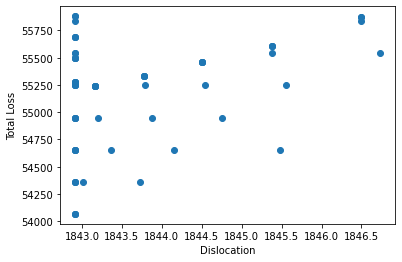

In [30]:
plt.scatter(listLoss_dfe,listDislocation_dfe)
#plt.ylim(min_func,max_func+0.001)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Dislocation",fontsize = 10)
plt.ylabel("Total Loss",fontsize = 10)
#plt.title("Pareto frontier: Economic Loss vs. functionality ")

Text(0.5, 0, 'Total Loss')

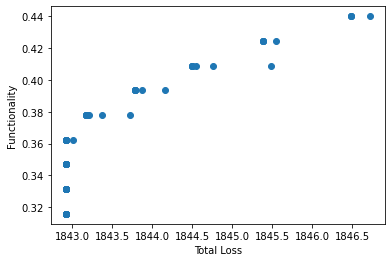

In [31]:
plt.scatter(listLoss_dfe,listHousingFunctionality_dfe)
#plt.ylim(min_func,max_func+0.001)
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel("Functionality",fontsize = 10)
plt.xlabel("Total Loss",fontsize = 10)
#plt.title("Pareto frontier: Economic Loss vs. functionality ")

Text(0, 0.5, 'Total dislocation')

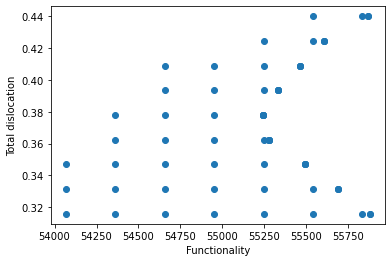

In [32]:
plt.scatter(listDislocation_dfe,listHousingFunctionality_dfe)
#plt.ylim(min_func,max_func+0.001)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Functionality",fontsize = 10)
plt.ylabel("Total dislocation",fontsize = 10)
#plt.title("Pareto frontier: Economic Loss vs. functionality ")

In [28]:
X = listLoss_dfe
Y = listDislocation_dfe
Z = listHousingFunctionality_dfe
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')

/Users/yunjiewen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Z contains NaN values. This may result in rendering artifacts.



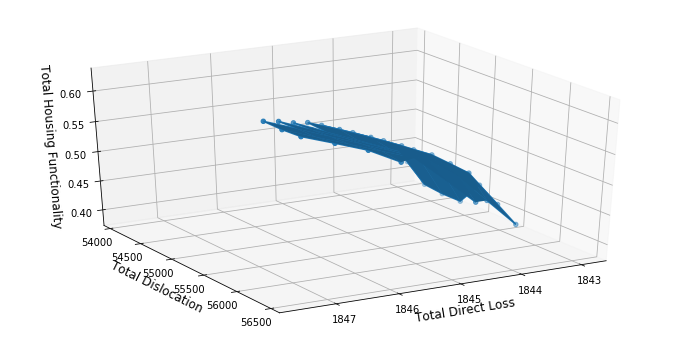

In [29]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
#ax.contour(plotx,ploty,plotz)
ax.scatter(plotx,ploty,plotz)
ax.plot_wireframe(plotx,ploty,plotz)
ax.plot_surface(plotx,ploty,plotz)
ax.set_xlabel('Total Direct Loss',fontsize = 12)
ax.set_ylabel('Total Dislocation',fontsize = 12)
ax.set_zlabel('Total Housing Functionality',fontsize = 12)
#ax.scatter([1169109228],[43638],[0.960],color = 'red',s = 100,marker ='o')
#ax.scatter([1153239333.58675],[44777.2703450079],[0.960430911319717],color = 'green',s = 100,marker ='o')
ax.grid()
ax.view_init(30,60) # view the plot from different angle
plt.show()


### Optimization 2
### Three competing objectives
### epsilon constraints on direct economic loss and functionality, optimize dislocation

In [34]:
# Optimization 2 ###############
# book keeping
listLoss_fed20 = []
listStrategy_fed20_x = []
listDislocation_fed20 = []
listDislocationBlockgroup_fed20 = []
listHousingFunctionality_fed20 = []
listStrategy_fed20_y=[]
epsilon_func = []
epsilon_eco  = []  

# epsilon steps
eco_range2, dislocation_range2,func_range2 = feasible_region(max_budget, 0.2)
eco_step2, dislocation_step2, func_step2 = \
            epsilon_steps(eco_range2, dislocation_range2, func_range2, 0.05)
counter = 0
best_dislocation = dislocation_range2[0]
for  func_bound in np.arange(func_range2[1], func_range2[0],func_step2): 
    print ("--------iteration step", counter,"--------------")
    print("+++++++++++functionality bound", func_bound,"++++++++++")      
    
     
    for eco_bound in np.arange(eco_range2[1], eco_range2[0], eco_step2):
        print("+++++++++++economic bound", eco_bound,"++++++++++")
        total_direct_loss, total_dislocation, strategy_x,func,strategy_y = \
                    epsilon_ecoloss_functionality(max_budget*0.2,eco_bound,func_bound)
        
        if total_dislocation !=-1:   
            
            epsilon_func.append(func_bound)
            epsilon_eco.append(eco_bound)
            listLoss_fed20.append(total_direct_loss)
            listDislocation_fed20.append(total_dislocation)
            listHousingFunctionality_fed20.append(func)
            listStrategy_fed20_x.append(strategy_x)
            listStrategy_fed20_y.append(strategy_y)
        else:
            print("Infeasible")
    counter += 1
loss_optimal20, dislocation_optimal20,func_optimal20 = optimal_points(listLoss_fed20,listDislocation_fed20,listHousingFunctionality_fed20)
df_fed20 = pd.DataFrame({"Economic_bound":epsilon_eco,
                               "Functionality_bound": epsilon_func,
                               "Economic_loss":listLoss_fed20,
                               "Dislocation":listDislocation_fed20, 
                               "Functionality":listHousingFunctionality_fed20})
print("---------------------Overview Result-------------------")
print(df_fed20)
df_fed20_optimal = pd.DataFrame({
                               "Economic_loss":loss_optimal20,
                               "Dislocation":dislocation_optimal20, 
                               "Functionality":func_optimal20})
print("---------------------Overview Optimal Result-------------------")
print(df_fed20_optimal)
#df_optimal_fed20.to_csv('results_03/26_Scalling_BasedOnAge_20Budget.csv',index = False)

Total population dislocation: 56211.986600027034
Total economic loss: 1842.9164240754646
Total housing funcnationality: 0.30011519816304233
Total population dislocation: 56718.05463851525
Total economic loss: 1848.4274851519492
Total housing funcnationality: 0.45567325841278583
--------iteration step 0 --------------
+++++++++++functionality bound 0.30011519816304233 ++++++++++
+++++++++++economic bound 1842.9164240754646 ++++++++++
Total population dislocation: 53772.353652347425
Total economic loss: 1842.9164240754699
Total housing funcnationality: 0.30183833715162534
+++++++++++economic bound 1843.191977129289 ++++++++++
Total population dislocation: 53772.353652347425
Total economic loss: 1842.9164240754699
Total housing funcnationality: 0.30183833715162534
+++++++++++economic bound 1843.4675301831132 ++++++++++
Total population dislocation: 53772.353652347425
Total economic loss: 1842.9164240754699
Total housing funcnationality: 0.30183833715162534
+++++++++++economic bound 1843.7

Total population dislocation: 53790.461218045
Total economic loss: 1842.9164240754646
Total housing funcnationality: 0.31567100418801664
+++++++++++economic bound 1843.191977129289 ++++++++++
Total population dislocation: 53790.150456084775
Total economic loss: 1842.924461375932
Total housing funcnationality: 0.31567100418801664
+++++++++++economic bound 1843.4675301831132 ++++++++++
Total population dislocation: 53790.150456084775
Total economic loss: 1842.924461375932
Total housing funcnationality: 0.31567100418801664
+++++++++++economic bound 1843.7430832369375 ++++++++++
Total population dislocation: 53790.150456084775
Total economic loss: 1842.924461375932
Total housing funcnationality: 0.31567100418801664
+++++++++++economic bound 1844.0186362907618 ++++++++++
Total population dislocation: 53790.150456084775
Total economic loss: 1842.924461375932
Total housing funcnationality: 0.31567100418801664
+++++++++++economic bound 1844.2941893445861 ++++++++++
Total population dislocation

Total population dislocation: 53861.214389093184
Total economic loss: 1843.2093403055408
Total housing funcnationality: 0.33122681021299094
+++++++++++economic bound 1843.7430832369375 ++++++++++
Total population dislocation: 53861.214389093184
Total economic loss: 1843.2093403055408
Total housing funcnationality: 0.33122681021299094
+++++++++++economic bound 1844.0186362907618 ++++++++++
Total population dislocation: 53861.214389093184
Total economic loss: 1843.2093403055408
Total housing funcnationality: 0.33122681021299094
+++++++++++economic bound 1844.2941893445861 ++++++++++
Total population dislocation: 53861.214389093184
Total economic loss: 1843.2093403055408
Total housing funcnationality: 0.33122681021299094
+++++++++++economic bound 1844.5697423984104 ++++++++++
Total population dislocation: 53861.214389093184
Total economic loss: 1843.2093403055408
Total housing funcnationality: 0.33122681021299094
+++++++++++economic bound 1844.8452954522347 ++++++++++
Total population dis

Total population dislocation: 53957.29191493242
Total economic loss: 1843.5217488874391
Total housing funcnationality: 0.34678261623796525
+++++++++++economic bound 1844.0186362907618 ++++++++++
Total population dislocation: 53957.29191493242
Total economic loss: 1843.5217488874391
Total housing funcnationality: 0.34678261623796525
+++++++++++economic bound 1844.2941893445861 ++++++++++
Total population dislocation: 53957.29191493242
Total economic loss: 1843.5217488874393
Total housing funcnationality: 0.34678261623796525
+++++++++++economic bound 1844.5697423984104 ++++++++++
Total population dislocation: 53957.29191493242
Total economic loss: 1843.5217488874393
Total housing funcnationality: 0.34678261623796525
+++++++++++economic bound 1844.8452954522347 ++++++++++
Total population dislocation: 53957.29191493242
Total economic loss: 1843.5217488874393
Total housing funcnationality: 0.34678261623796525
+++++++++++economic bound 1845.120848506059 ++++++++++
Total population dislocati

Total population dislocation: 54076.58452410898
Total economic loss: 1843.9230491788817
Total housing funcnationality: 0.36233842226293955
+++++++++++economic bound 1844.5697423984104 ++++++++++
Total population dislocation: 54076.58452410898
Total economic loss: 1843.9230491788817
Total housing funcnationality: 0.36233842226293955
+++++++++++economic bound 1844.8452954522347 ++++++++++
Total population dislocation: 54076.58452410898
Total economic loss: 1843.9230491788817
Total housing funcnationality: 0.36233842226293955
+++++++++++economic bound 1845.120848506059 ++++++++++
Total population dislocation: 54076.58452410898
Total economic loss: 1843.9230491788817
Total housing funcnationality: 0.36233842226293955
+++++++++++economic bound 1845.3964015598833 ++++++++++
Total population dislocation: 54076.58452410898
Total economic loss: 1843.9230491788817
Total housing funcnationality: 0.36233842226293955
+++++++++++economic bound 1845.6719546137076 ++++++++++
Total population dislocati

Total population dislocation: 54227.90330139868
Total economic loss: 1844.4586219527623
Total housing funcnationality: 0.37789422828791386
+++++++++++economic bound 1845.3964015598833 ++++++++++
Total population dislocation: 54227.90330139868
Total economic loss: 1844.4586219527623
Total housing funcnationality: 0.37789422828791386
+++++++++++economic bound 1845.6719546137076 ++++++++++
Total population dislocation: 54227.90330139868
Total economic loss: 1844.4586219527623
Total housing funcnationality: 0.37789422828791386
+++++++++++economic bound 1845.947507667532 ++++++++++
Total population dislocation: 54227.90330139868
Total economic loss: 1844.4586219527623
Total housing funcnationality: 0.37789422828791386
+++++++++++economic bound 1846.2230607213562 ++++++++++
Total population dislocation: 54227.90330139868
Total economic loss: 1844.4586219527623
Total housing funcnationality: 0.37789422828791386
+++++++++++economic bound 1846.4986137751805 ++++++++++
Total population dislocati

Total population dislocation: 54413.68172407291
Total economic loss: 1845.0927067841437
Total housing funcnationality: 0.39345003431288816
+++++++++++economic bound 1846.7741668290048 ++++++++++
Total population dislocation: 54413.68172407291
Total economic loss: 1845.0927067841437
Total housing funcnationality: 0.39345003431288816
+++++++++++economic bound 1847.049719882829 ++++++++++
Total population dislocation: 54413.68172407291
Total economic loss: 1845.0927067841437
Total housing funcnationality: 0.39345003431288816
+++++++++++economic bound 1847.3252729366534 ++++++++++
Total population dislocation: 54413.68172407291
Total economic loss: 1845.0927067841437
Total housing funcnationality: 0.39345003431288816
+++++++++++economic bound 1847.6008259904777 ++++++++++
Total population dislocation: 54413.68172407291
Total economic loss: 1845.0927067841437
Total housing funcnationality: 0.39345003431288816
+++++++++++economic bound 1847.876379044302 ++++++++++
Total population dislocatio

Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.191977129289 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.4675301831132 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.7430832369375 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1844.0186362907618 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1844.2941893445861 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1844.5697423984104 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1844.8452954522347 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1845.120848506059 ++++++++++
Total population dislocation: 55099.19844031953
Total economic loss: 1845.120848506059
Total housing funcnationality: 0.4167837433503496
+++++++++++economic bound 1845.3964015598833 ++++++++++
Total population dislocation: 54932.00466168327
Total economic loss: 1845.3964015598833
Total housing funcnationality: 0.

Total population dislocation: 55168.92534820689
Total economic loss: 1846.7122182330709
Total housing funcnationality: 0.43233954937532393
+++++++++++economic bound 1847.876379044302 ++++++++++
Total population dislocation: 55168.92534820689
Total economic loss: 1846.7122182330709
Total housing funcnationality: 0.43233954937532393
+++++++++++economic bound 1848.1519320981263 ++++++++++
Total population dislocation: 55168.92534820689
Total economic loss: 1846.7122182330709
Total housing funcnationality: 0.43233954937532393
--------iteration step 18 --------------
+++++++++++functionality bound 0.4401174523878111 ++++++++++
+++++++++++economic bound 1842.9164240754646 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.191977129289 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.4675301831132 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1843.7430832369375 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1

Range of Functionality: 0.30183833715162534 , 0.44789535540029823
Range of Dislocation: 53772.353652347425 , 55886.742654350484
Range of Economic loss: 1842.9164240754646 , 1847.597265967379


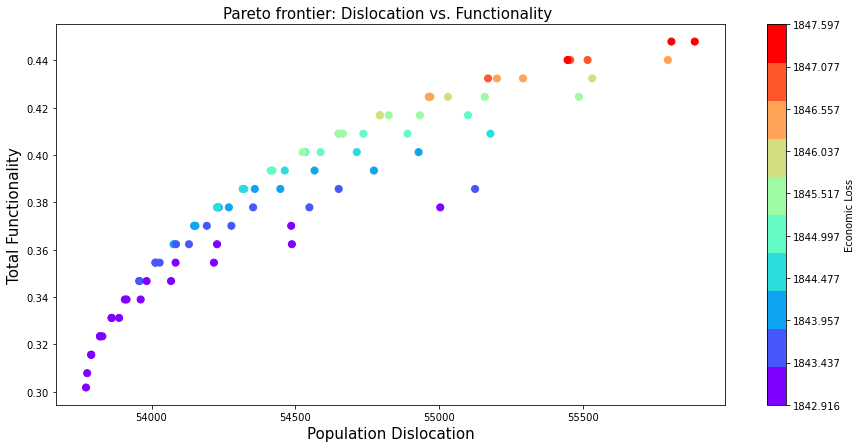

In [35]:
plt.figure(figsize=(15,7))
plt.scatter(dislocation_optimal20,func_optimal20,c=loss_optimal20,cmap=plt.cm.get_cmap('rainbow', 10),s = 50 )
v1 = np.linspace(min(loss_optimal20), max(loss_optimal20), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Economic Loss' )
plt.clim(min(loss_optimal20), max(loss_optimal20))
plt.xlabel("Population Dislocation",fontsize = 15)
plt.ylabel("Total Functionality",fontsize = 15)
plt.title("Pareto frontier: Dislocation vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal20),",",max(func_optimal20))
print("Range of Dislocation:",min(dislocation_optimal20),",",max(dislocation_optimal20))
print("Range of Economic loss:",min(loss_optimal20),",",max(loss_optimal20))

Range of Functionality: 0.30183833715162534 , 0.44789535540029823
Range of Dislocation: 53772.353652347425 , 55886.742654350484
Range of Economic loss(Million Dollar): 1842.9164240754646 , 1847.597265967379


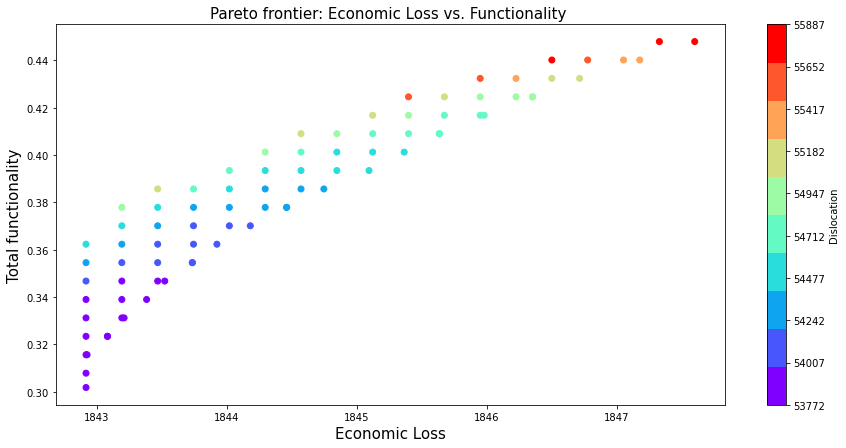

In [36]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal20,func_optimal20,c=dislocation_optimal20,cmap =plt.cm.get_cmap('rainbow', 10))
v1 = np.linspace(min(dislocation_optimal20), max(dislocation_optimal20), 10, endpoint=True)
plt.colorbar(ticks = v1, label = "Dislocation")
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Total functionality",fontsize = 15)
plt.title("Pareto frontier: Economic Loss vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal20),",",max(func_optimal20))
print("Range of Dislocation:",min(dislocation_optimal20),",",max(dislocation_optimal20))
print("Range of Economic loss(Million Dollar):",min(loss_optimal20),",",max(loss_optimal20))

Range of Functionality: 0.30183833715162534 , 0.44789535540029823
Range of Dislocation: 53772.353652347425 , 55886.742654350484
Range of Economic loss(Million Dollar): 1842.9164240754646 , 1847.597265967379


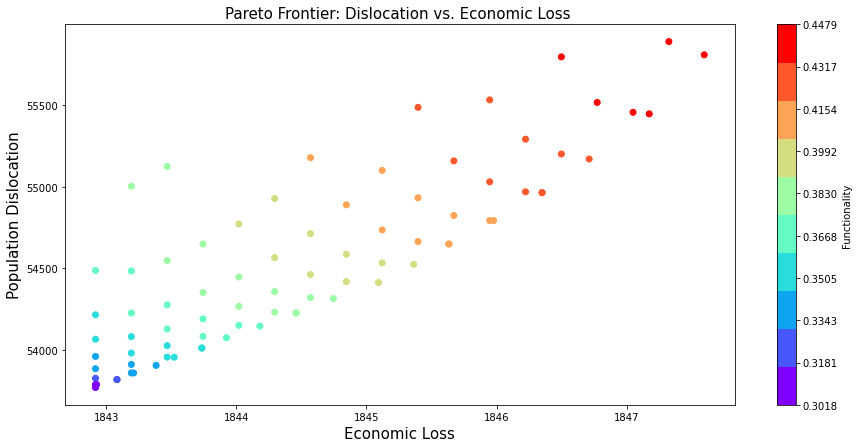

In [37]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal20,dislocation_optimal20,c=func_optimal20,cmap =plt.cm.get_cmap('rainbow', 10))
v1 = np.linspace(min(func_optimal20), max(func_optimal20), 10, endpoint=True)
plt.colorbar(ticks = v1, label='Functionality')
plt.ylabel("Population Dislocation",fontsize = 15)
plt.xlabel("Economic Loss",fontsize = 15)
plt.title("Pareto Frontier: Dislocation vs. Economic Loss ",fontsize = 15)
print("Range of Functionality:",min(func_optimal20),",",max(func_optimal20))
print("Range of Dislocation:",min(dislocation_optimal20),",",max(dislocation_optimal20))
print("Range of Economic loss(Million Dollar):",min(loss_optimal20),",",max(loss_optimal20))

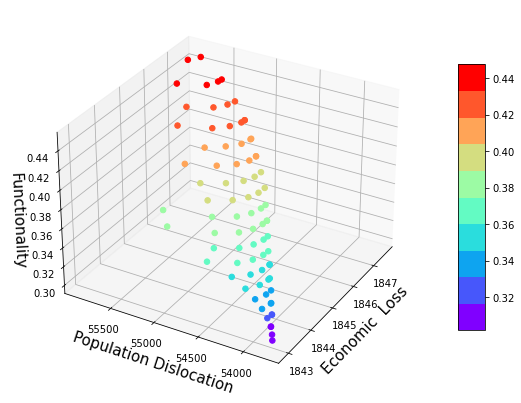

In [39]:
X = loss_optimal20
Y = dislocation_optimal20
Z = func_optimal20

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Y),np.max(Y),10))
#plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')
cm = plt.cm.get_cmap('rainbow', 10)    
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe(plotx,ploty,plotz)
sc = ax.scatter(X,Y,Z,c = Z, s = 30, alpha = 1, cmap =cm)
ax.set_xlabel('Economic  Loss',fontsize = 15)
ax.set_ylabel('Population Dislocation',fontsize = 15)
ax.set_zlabel('Functionality',fontsize = 15)
ax.view_init(30,210) # view the plot from different angle
fig.colorbar(sc,shrink=0.7, aspect=10)
plt.show()

# 40% budget

In [41]:
# epsilon steps
eco_range4, dislocation_range4,func_range4 = feasible_region(max_budget, 0.4)
eco_step4, dislocation_step4, func_step4 = \
            epsilon_steps(eco_range4, dislocation_range4, func_range4, 0.05)

Total population dislocation: 52161.04579299263
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6052066549948037
Total population dislocation: 53997.319389654986
Total economic loss: 1679.4834694307485
Total housing funcnationality: 0.929391320643259


In [42]:
# book keeping
listLoss_fed40 = []
listStrategy_fed40_x = []
listDislocation_fed40 = []
listDislocationBlockgroup_fed40 = []
listHousingFunctionality_fed40 = []
listStrategy_fed40_y=[]
epsilon_func = []
epsilon_eco  = []
    
counter = 0
for  func_bound in np.arange(func_range4[1], func_range4[0],func_step4): # the maximum value of functionality is 1
    print ("--------iteration step", counter,"--------------")
    print("+++++++++++functionality bound", func_bound,"++++++++++")
           
    
    
    for eco_bound in np.arange(eco_range4[1], eco_range4[0], eco_step4):
        print("+++++++++++economic bound", eco_bound,"++++++++++")
        total_direct_loss, total_dislocation, strategy_x,func,strategy_y = \
                    epsilon_ecoloss_functionality(max_budget*0.4,eco_bound,func_bound)
        
        if total_dislocation !=-1:
            epsilon_func.append(func_bound)
            epsilon_eco.append(eco_bound)
        # add epsilon constraint on dislocation and total economic loss 
        # while optimizing housing functionality
        #total_direct_loss, total_dislocation, strategy_ite,dislo_blockgroup,func = \
                #epsilon_ecoloss_func(max_budget*0.5,eco_bound,func_bound)
            listLoss_fed40.append(total_direct_loss)
            listDislocation_fed40.append(total_dislocation)
            listHousingFunctionality_fed40.append(func)
            listStrategy_fed40_x.append(strategy_x)
            listStrategy_fed40_y.append(strategy_y)
        else:
            print("Infeasible")
    counter += 1
df_optimal_fed40 = pd.DataFrame({"Economic_bound":epsilon_eco,
                               "Functionality_bound": epsilon_func,
                               "Economic_loss":listLoss_fed40,
                               "Dislocation":listDislocation_fed40, 
                               "Functionality":listHousingFunctionality_fed40})
print("---------------------Overview Result-------------------")
print(df_optimal_fed40)

loss_optimal40, dislocation_optimal40,func_optimal40 = optimal_points(listLoss_fed40,listDislocation_fed40,listHousingFunctionality_fed40)
df_fed40_optimal = pd.DataFrame({
                               "Economic_loss":loss_optimal40,
                               "Dislocation":dislocation_optimal40, 
                               "Functionality":func_optimal40})
print("---------------------Overview Optimal Result-------------------")
print(df_fed40_optimal)

--------iteration step 0 --------------
+++++++++++functionality bound 0.6052066549948037 ++++++++++
+++++++++++economic bound 1668.1008181509294 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1668.6699507149203 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1669.2390832789113 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1669.8082158429022 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1670.3773484068931 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss

Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1669.2390832789113 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1669.8082158429022 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1670.3773484068931 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1670.946480970884 ++++++++++
Total population dislocation: 49699.87748434984
Total economic loss: 1668.1008181509294
Total housing funcnationality: 0.6405100669460754
+++++++++++economic bound 1671.515613534875 ++++++++++
Total population dislocation: 49

Total population dislocation: 49731.96748031407
Total economic loss: 1668.3295388030983
Total housing funcnationality: 0.6700435881244947
+++++++++++economic bound 1670.3773484068931 ++++++++++
Total population dislocation: 49731.96748031407
Total economic loss: 1668.3295388030983
Total housing funcnationality: 0.6700435881244947
+++++++++++economic bound 1670.946480970884 ++++++++++
Total population dislocation: 49731.96748031407
Total economic loss: 1668.3295388030983
Total housing funcnationality: 0.6700435881244947
+++++++++++economic bound 1671.515613534875 ++++++++++
Total population dislocation: 49731.96748031407
Total economic loss: 1668.3295388030983
Total housing funcnationality: 0.6700435881244947
+++++++++++economic bound 1672.084746098866 ++++++++++
Total population dislocation: 49731.96748031407
Total economic loss: 1668.3295388030983
Total housing funcnationality: 0.6700435881244947
+++++++++++economic bound 1672.6538786628569 ++++++++++
Total population dislocation: 497

Total population dislocation: 49815.243326338095
Total economic loss: 1668.8945176899565
Total housing funcnationality: 0.7024620546893402
+++++++++++economic bound 1671.515613534875 ++++++++++
Total population dislocation: 49815.243326338095
Total economic loss: 1668.8945176899565
Total housing funcnationality: 0.7024620546893402
+++++++++++economic bound 1672.084746098866 ++++++++++
Total population dislocation: 49815.243326338095
Total economic loss: 1668.8945176899565
Total housing funcnationality: 0.7024620546893402
+++++++++++economic bound 1672.6538786628569 ++++++++++
Total population dislocation: 49815.243326338095
Total economic loss: 1668.8945176899565
Total housing funcnationality: 0.7024620546893402
+++++++++++economic bound 1673.2230112268478 ++++++++++
Total population dislocation: 49815.243326338095
Total economic loss: 1668.8945176899565
Total housing funcnationality: 0.7024620546893402
+++++++++++economic bound 1673.7921437908387 ++++++++++
Total population dislocatio

Total population dislocation: 49941.082737304016
Total economic loss: 1669.7240328750643
Total housing funcnationality: 0.7348805212541857
+++++++++++economic bound 1673.2230112268478 ++++++++++
Total population dislocation: 49941.082737304016
Total economic loss: 1669.7240328750643
Total housing funcnationality: 0.7348805212541857
+++++++++++economic bound 1673.7921437908387 ++++++++++
Total population dislocation: 49941.082737304016
Total economic loss: 1669.7240328750643
Total housing funcnationality: 0.7348805212541857
+++++++++++economic bound 1674.3612763548297 ++++++++++
Total population dislocation: 49941.082737304016
Total economic loss: 1669.7240328750643
Total housing funcnationality: 0.7348805212541857
+++++++++++economic bound 1674.9304089188206 ++++++++++
Total population dislocation: 49941.082737304016
Total economic loss: 1669.7240328750643
Total housing funcnationality: 0.7348805212541857
+++++++++++economic bound 1675.4995414828115 ++++++++++
Total population dislocat

Total population dislocation: 50119.78395231486
Total economic loss: 1670.7237681016045
Total housing funcnationality: 0.7672989878190312
+++++++++++economic bound 1676.0686740468025 ++++++++++
Total population dislocation: 50119.78395231486
Total economic loss: 1670.7237681016045
Total housing funcnationality: 0.7672989878190312
+++++++++++economic bound 1676.6378066107934 ++++++++++
Total population dislocation: 50119.78395231486
Total economic loss: 1670.7237681016045
Total housing funcnationality: 0.7672989878190312
+++++++++++economic bound 1677.2069391747843 ++++++++++
Total population dislocation: 50119.78395231486
Total economic loss: 1670.7237681016045
Total housing funcnationality: 0.7672989878190312
+++++++++++economic bound 1677.7760717387753 ++++++++++
Total population dislocation: 50119.78395231486
Total economic loss: 1670.7237681016045
Total housing funcnationality: 0.7672989878190312
+++++++++++economic bound 1678.3452043027662 ++++++++++
Total population dislocation: 

Gurobi status is 4
Infeasible
+++++++++++economic bound 1668.6699507149203 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1669.2390832789113 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1669.8082158429022 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1670.3773484068931 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1670.946480970884 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1671.515613534875 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1672.084746098866 ++++++++++
Total population dislocation: 50738.36732746172
Total economic loss: 1672.084746098866
Total housing funcnationality: 0.8159266876662994
+++++++++++economic bound 1672.6538786628569 ++++++++++
Total population dislocation: 50524.03870381155
Total economic loss: 1672.609209300515
Total housing funcnationality: 0.8159266876662994
+++++++++++economic bound 1673.2230112268478 ++++++++++
Total populatio

Total population dislocation: 50928.45504676838
Total economic loss: 1673.9990046754222
Total housing funcnationality: 0.8483451542311449
+++++++++++economic bound 1677.7760717387753 ++++++++++
Total population dislocation: 50928.45504676838
Total economic loss: 1673.9990046754222
Total housing funcnationality: 0.8483451542311449
+++++++++++economic bound 1678.3452043027662 ++++++++++
Total population dislocation: 50928.45504676838
Total economic loss: 1673.9990046754222
Total housing funcnationality: 0.8483451542311449
+++++++++++economic bound 1678.9143368667571 ++++++++++
Total population dislocation: 50928.45504676838
Total economic loss: 1673.9990046754222
Total housing funcnationality: 0.8483451542311449
--------iteration step 16 --------------
+++++++++++functionality bound 0.8645543875135676 ++++++++++
+++++++++++economic bound 1668.1008181509294 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1668.6699507149203 ++++++++++
Gurobi status is 4
Infeasible
++++++

Total population dislocation: 52005.15537589812
Total economic loss: 1676.7586501486235
Total housing funcnationality: 0.8969728540784131
+++++++++++economic bound 1678.9143368667571 ++++++++++
Total population dislocation: 52005.15537589812
Total economic loss: 1676.7586501486235
Total housing funcnationality: 0.8969728540784131
--------iteration step 19 --------------
+++++++++++functionality bound 0.9131820873608358 ++++++++++
+++++++++++economic bound 1668.1008181509294 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1668.6699507149203 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1669.2390832789113 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1669.8082158429022 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1670.3773484068931 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1670.946480970884 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1671.515613534875 +++++++

Range of Functionality: 0.6405100669460754 , 0.9131820873608358
Range of Dislocation: 49699.87748434984 , 53511.48257511863
Range of Economic loss: 1668.1008181509294 , 1678.040873070423


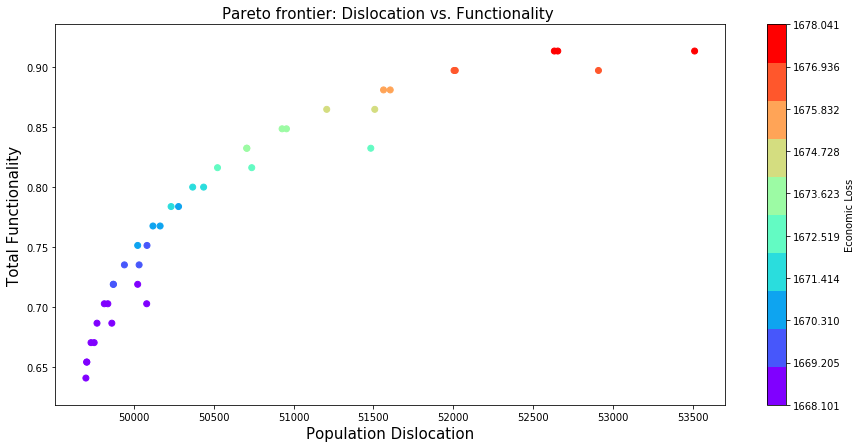

In [116]:
plt.figure(figsize=(15,7))
plt.scatter(dislocation_optimal40,func_optimal40,c=loss_optimal40,cmap=plt.cm.get_cmap('rainbow', 10) )
v1 = np.linspace(min(loss_optimal40), max(loss_optimal40), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Economic Loss' )
plt.clim(min(loss_optimal40), max(loss_optimal40))
plt.xlabel("Population Dislocation",fontsize = 15)
plt.ylabel("Total Functionality",fontsize = 15)
plt.title("Pareto frontier: Dislocation vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal40),",",max(func_optimal40))
print("Range of Dislocation:",min(dislocation_optimal40),",",max(dislocation_optimal40))
print("Range of Economic loss:",min(loss_optimal40),",",max(loss_optimal40))

Range of Functionality: 0.6405100669460754 , 0.9131820873608358
Range of Dislocation: 49699.87748434984 , 53511.48257511863
Range of Economic loss(Million Dollar): 1668.1008181509294 , 1678.040873070423


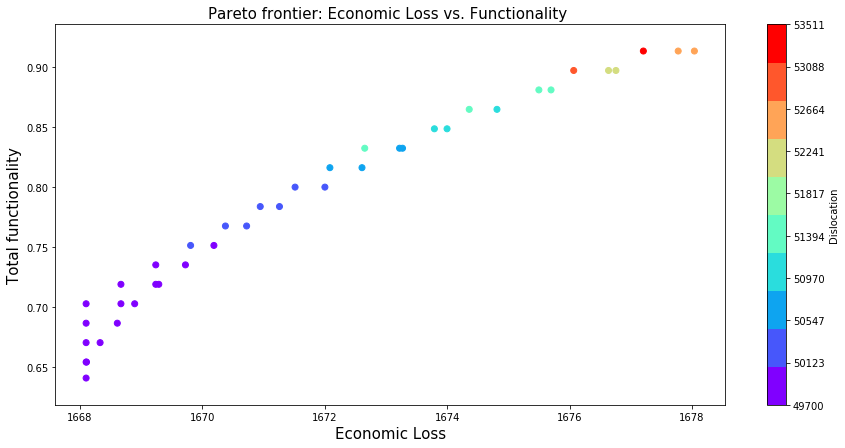

In [117]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal40,func_optimal40,c=dislocation_optimal40,cmap =plt.cm.get_cmap('rainbow', 10))
v1 = np.linspace(min(dislocation_optimal40), max(dislocation_optimal40), 10, endpoint=True)
plt.colorbar(ticks = v1, label = "Dislocation")
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Total functionality",fontsize = 15)
plt.title("Pareto frontier: Economic Loss vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal40),",",max(func_optimal40))
print("Range of Dislocation:",min(dislocation_optimal40),",",max(dislocation_optimal40))
print("Range of Economic loss(Million Dollar):",min(loss_optimal40),",",max(loss_optimal40))

Range of Functionality: 0.6405100669460754 , 0.9131820873608358
Range of Dislocation: 49699.87748434984 , 53511.48257511863
Range of Economic loss(Million Dollar): 1668.1008181509294 , 1678.040873070423


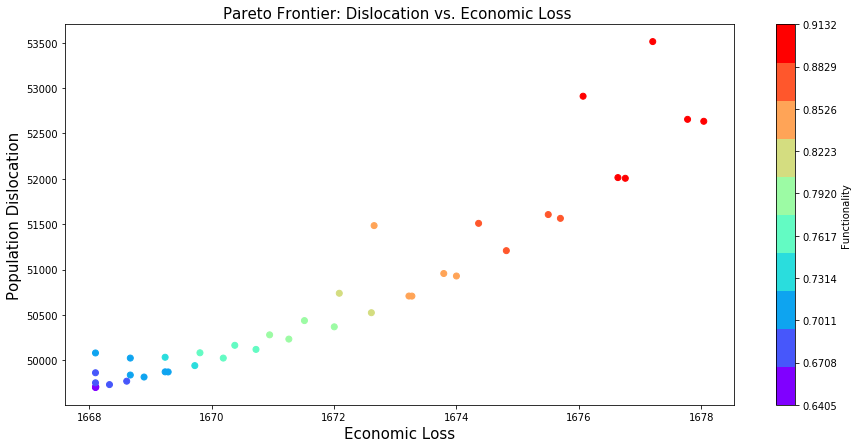

In [118]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal40,dislocation_optimal40,c=func_optimal40,cmap =plt.cm.get_cmap('rainbow', 10))
v1 = np.linspace(min(func_optimal40), max(func_optimal40), 10, endpoint=True)
plt.colorbar(ticks = v1, label='Functionality')
plt.ylabel("Population Dislocation",fontsize = 15)
plt.xlabel("Economic Loss",fontsize = 15)
plt.title("Pareto Frontier: Dislocation vs. Economic Loss ",fontsize = 15)
print("Range of Functionality:",min(func_optimal40),",",max(func_optimal40))
print("Range of Dislocation:",min(dislocation_optimal40),",",max(dislocation_optimal40))
print("Range of Economic loss(Million Dollar):",min(loss_optimal40),",",max(loss_optimal40))

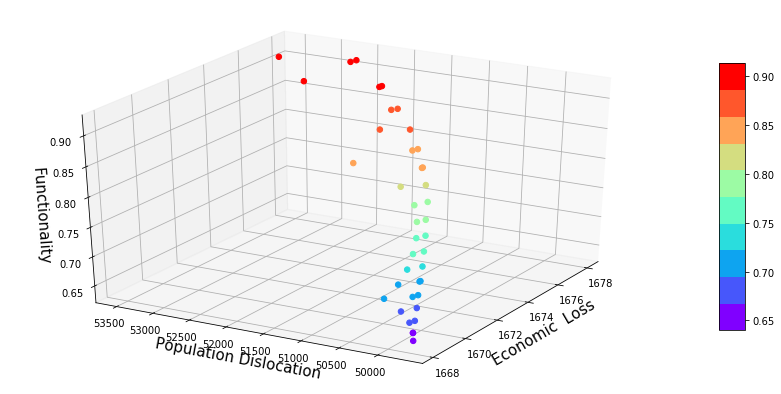

In [119]:
X2 = loss_optimal40
Y2 = dislocation_optimal40
Z2 = func_optimal40

plotx4,ploty4, = np.meshgrid(np.linspace(np.min(X2),np.max(X2),10),\
                           np.linspace(np.min(Y2),np.max(Y2),10))
plotz4 = interp.griddata((X2,Y2),Z2,(plotx4,ploty4),method='linear')
cm = plt.cm.get_cmap('rainbow', 10)    
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe(plotx,ploty,plotz)
sc = ax.scatter(X2,Y2,Z2,c = Z2, s = 30, alpha = 1, cmap =cm)
ax.set_xlabel('Economic  Loss',fontsize = 15)
ax.set_ylabel('Population Dislocation',fontsize = 15)
ax.set_zlabel('Functionality',fontsize = 15)
ax.view_init(30,210) # view the plot from different angle
fig.colorbar(sc,shrink=0.7, aspect=10)
plt.show()

### 60% budget level

In [48]:
# epsilon steps
eco_range6, dislocation_range6,func_range6 = feasible_region(max_budget, 0.6)
eco_step6, dislocation_step6, func_step6 = \
            epsilon_steps(eco_range6, dislocation_range6, func_range6, 0.05)

Total population dislocation: 48207.60050592835
Total economic loss: 1493.2852122263942
Total housing funcnationality: 0.8463550632228702
Total population dislocation: 51609.37750439515
Total economic loss: 1512.5044980418027
Total housing funcnationality: 0.9675537658431073


In [49]:
# book keeping
listLoss_fed60 = []
listStrategy_fed60_x = []
listDislocation_fed60 = []
listDislocationBlockgroup_fed60 = []
listHousingFunctionality_fed60 = []
listStrategy_fed60_y=[]
epsilon_func = []
epsilon_eco  = []
    
counter = 0
for  func_bound in np.arange(func_range6[1], func_range6[0],func_step6): # the maximum value of functionality is 1
    print ("--------iteration step", counter,"--------------")
    print("+++++++++++functionality bound", func_bound,"++++++++++")
           
    
    
    for eco_bound in np.arange(eco_range6[1], eco_range6[0], eco_step6):
        print("+++++++++++economic bound", eco_bound,"++++++++++")
        total_direct_loss, total_dislocation, strategy_x,func,strategy_y = \
                    epsilon_ecoloss_functionality(max_budget*0.6,eco_bound,func_bound)
        
        if total_dislocation !=-1:
            epsilon_func.append(func_bound)
            epsilon_eco.append(eco_bound)
        # add epsilon constraint on dislocation and total economic loss 
        # while optimizing housing functionality
        #total_direct_loss, total_dislocation, strategy_ite,dislo_blockgroup,func = \
                #epsilon_ecoloss_func(max_budget*0.5,eco_bound,func_bound)
            listLoss_fed60.append(total_direct_loss)
            listDislocation_fed60.append(total_dislocation)
            listHousingFunctionality_fed60.append(func)
            listStrategy_fed60_x.append(strategy_x)
            listStrategy_fed60_y.append(strategy_y)
        else:
            print("Infeasible")
    counter += 1
df_fed60 = pd.DataFrame({"Economic_bound":epsilon_eco,
                               "Functionality_bound": epsilon_func,
                               "Economic_loss":listLoss_fed60,
                               "Dislocation":listDislocation_fed60, 
                               "Functionality":listHousingFunctionality_fed60})
print("---------------------Overview Result-------------------")
print(df_fed60)

loss_optimal60, dislocation_optimal60,func_optimal60 = optimal_points(listLoss_fed60,listDislocation_fed60,listHousingFunctionality_fed60)
df_fed60_optimal = pd.DataFrame({
                               "Economic_loss":loss_optimal60,
                               "Dislocation":dislocation_optimal60, 
                               "Functionality":func_optimal60})
print("---------------------Overview Optimal Result-------------------")
print(df_fed60_optimal)

--------iteration step 0 --------------
+++++++++++functionality bound 0.8452409861817902 ++++++++++
+++++++++++economic bound 1493.2852122263942 ++++++++++
Total population dislocation: 46990.17546134249
Total economic loss: 1493.2852122263942
Total housing funcnationality: 0.8452766789351591
+++++++++++economic bound 1494.2461765171645 ++++++++++
Total population dislocation: 46989.974179681725
Total economic loss: 1493.3218984976932
Total housing funcnationality: 0.8452409861817902
+++++++++++economic bound 1495.2071408079348 ++++++++++
Total population dislocation: 46989.974179681725
Total economic loss: 1493.3218984976932
Total housing funcnationality: 0.8452409861817902
+++++++++++economic bound 1496.1681050987052 ++++++++++
Total population dislocation: 46989.974179681725
Total economic loss: 1493.3218984976932
Total housing funcnationality: 0.8452409861817902
+++++++++++economic bound 1497.1290693894755 ++++++++++
Total population dislocation: 46989.974179681725
Total economic 

Total population dislocation: 47002.10986455069
Total economic loss: 1493.4231525546536
Total housing funcnationality: 0.857472264147922
+++++++++++economic bound 1495.2071408079348 ++++++++++
Total population dislocation: 47002.10986455069
Total economic loss: 1493.4231525546536
Total housing funcnationality: 0.857472264147922
+++++++++++economic bound 1496.1681050987052 ++++++++++
Total population dislocation: 47002.10986455069
Total economic loss: 1493.4231525546536
Total housing funcnationality: 0.857472264147922
+++++++++++economic bound 1497.1290693894755 ++++++++++
Total population dislocation: 47002.10986455069
Total economic loss: 1493.4231525546536
Total housing funcnationality: 0.857472264147922
+++++++++++economic bound 1498.0900336802458 ++++++++++
Total population dislocation: 47002.10986455069
Total economic loss: 1493.4231525546536
Total housing funcnationality: 0.857472264147922
+++++++++++economic bound 1499.0509979710162 ++++++++++
Total population dislocation: 47002

Total population dislocation: 47024.51950324093
Total economic loss: 1493.5623024249367
Total housing funcnationality: 0.8697035421140538
+++++++++++economic bound 1497.1290693894755 ++++++++++
Total population dislocation: 47024.51950324093
Total economic loss: 1493.5623024249367
Total housing funcnationality: 0.8697035421140538
+++++++++++economic bound 1498.0900336802458 ++++++++++
Total population dislocation: 47024.51950324093
Total economic loss: 1493.5623024249367
Total housing funcnationality: 0.8697035421140538
+++++++++++economic bound 1499.0509979710162 ++++++++++
Total population dislocation: 47024.51950324093
Total economic loss: 1493.5623024249367
Total housing funcnationality: 0.8697035421140538
+++++++++++economic bound 1500.0119622617865 ++++++++++
Total population dislocation: 47024.51950324093
Total economic loss: 1493.5623024249367
Total housing funcnationality: 0.8697035421140538
+++++++++++economic bound 1500.9729265525568 ++++++++++
Total population dislocation: 

Total population dislocation: 47055.078402223284
Total economic loss: 1493.937477669172
Total housing funcnationality: 0.8819348200801855
+++++++++++economic bound 1499.0509979710162 ++++++++++
Total population dislocation: 47055.078402223284
Total economic loss: 1493.937477669172
Total housing funcnationality: 0.8819348200801855
+++++++++++economic bound 1500.0119622617865 ++++++++++
Total population dislocation: 47055.078402223284
Total economic loss: 1493.937477669172
Total housing funcnationality: 0.8819348200801855
+++++++++++economic bound 1500.9729265525568 ++++++++++
Total population dislocation: 47055.078402223284
Total economic loss: 1493.937477669172
Total housing funcnationality: 0.8819348200801855
+++++++++++economic bound 1501.9338908433272 ++++++++++
Total population dislocation: 47055.078402223284
Total economic loss: 1493.937477669172
Total housing funcnationality: 0.8819348200801855
+++++++++++economic bound 1502.8948551340975 ++++++++++
Total population dislocation: 

Total population dislocation: 47097.86536405803
Total economic loss: 1494.3455616883432
Total housing funcnationality: 0.8941660980463173
+++++++++++economic bound 1501.9338908433272 ++++++++++
Total population dislocation: 47097.86536405803
Total economic loss: 1494.3455616883432
Total housing funcnationality: 0.8941660980463173
+++++++++++economic bound 1502.8948551340975 ++++++++++
Total population dislocation: 47097.86536405803
Total economic loss: 1494.3455616883432
Total housing funcnationality: 0.8941660980463173
+++++++++++economic bound 1503.8558194248678 ++++++++++
Total population dislocation: 47097.86536405803
Total economic loss: 1494.3455616883432
Total housing funcnationality: 0.8941660980463173
+++++++++++economic bound 1504.8167837156382 ++++++++++
Total population dislocation: 47097.86536405803
Total economic loss: 1494.3455616883432
Total housing funcnationality: 0.8941660980463173
+++++++++++economic bound 1505.7777480064085 ++++++++++
Total population dislocation: 

Total population dislocation: 47160.22656231652
Total economic loss: 1494.9436510026112
Total housing funcnationality: 0.9063973760124491
+++++++++++economic bound 1504.8167837156382 ++++++++++
Total population dislocation: 47160.22656231652
Total economic loss: 1494.9436510026112
Total housing funcnationality: 0.9063973760124491
+++++++++++economic bound 1505.7777480064085 ++++++++++
Total population dislocation: 47160.22656231652
Total economic loss: 1494.9436510026112
Total housing funcnationality: 0.9063973760124491
+++++++++++economic bound 1506.7387122971788 ++++++++++
Total population dislocation: 47160.22656231652
Total economic loss: 1494.9436510026112
Total housing funcnationality: 0.9063973760124491
+++++++++++economic bound 1507.6996765879492 ++++++++++
Total population dislocation: 47160.22656231652
Total economic loss: 1494.9436510026112
Total housing funcnationality: 0.9063973760124491
+++++++++++economic bound 1508.6606408787195 ++++++++++
Total population dislocation: 

Total population dislocation: 47245.29402466224
Total economic loss: 1495.6750778680964
Total housing funcnationality: 0.9186286539785808
+++++++++++economic bound 1508.6606408787195 ++++++++++
Total population dislocation: 47245.29402466224
Total economic loss: 1495.6750778680964
Total housing funcnationality: 0.9186286539785808
+++++++++++economic bound 1509.6216051694898 ++++++++++
Total population dislocation: 47245.29402466224
Total economic loss: 1495.6750778680964
Total housing funcnationality: 0.9186286539785808
+++++++++++economic bound 1510.5825694602602 ++++++++++
Total population dislocation: 47245.29402466224
Total economic loss: 1495.6750778680964
Total housing funcnationality: 0.9186286539785808
+++++++++++economic bound 1511.5435337510305 ++++++++++
Total population dislocation: 47245.29402466224
Total economic loss: 1495.6750778680964
Total housing funcnationality: 0.9186286539785808
--------iteration step 13 --------------
+++++++++++functionality bound 0.924744292961

Gurobi status is 4
Infeasible
+++++++++++economic bound 1494.2461765171645 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1495.2071408079348 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1496.1681050987052 ++++++++++
Gurobi status is 4
Infeasible
+++++++++++economic bound 1497.1290693894755 ++++++++++
Total population dislocation: 47444.80632894144
Total economic loss: 1497.1129964205477
Total housing funcnationality: 0.9369755709277785
+++++++++++economic bound 1498.0900336802458 ++++++++++
Total population dislocation: 47444.80632894144
Total economic loss: 1497.1129964205477
Total housing funcnationality: 0.9369755709277785
+++++++++++economic bound 1499.0509979710162 ++++++++++
Total population dislocation: 47444.80632894144
Total economic loss: 1497.1129964205477
Total housing funcnationality: 0.9369755709277785
+++++++++++economic bound 1500.0119622617865 ++++++++++
Total population dislocation: 47444.80632894144
Total economic loss: 1497.

Total population dislocation: 47689.676195243606
Total economic loss: 1498.3410243493527
Total housing funcnationality: 0.9492068488939103
+++++++++++economic bound 1502.8948551340975 ++++++++++
Total population dislocation: 47689.676195243606
Total economic loss: 1498.3410243493527
Total housing funcnationality: 0.9492068488939103
+++++++++++economic bound 1503.8558194248678 ++++++++++
Total population dislocation: 47689.676195243606
Total economic loss: 1498.3410243493527
Total housing funcnationality: 0.9492068488939103
+++++++++++economic bound 1504.8167837156382 ++++++++++
Total population dislocation: 47689.676195243606
Total economic loss: 1498.3410243493527
Total housing funcnationality: 0.9492068488939103
+++++++++++economic bound 1505.7777480064085 ++++++++++
Total population dislocation: 47689.676195243606
Total economic loss: 1498.3410243493527
Total housing funcnationality: 0.9492068488939103
+++++++++++economic bound 1506.7387122971788 ++++++++++
Total population dislocat

Total population dislocation: 48744.668549414055
Total economic loss: 1503.5524043074283
Total housing funcnationality: 0.961438126860042
+++++++++++economic bound 1510.5825694602602 ++++++++++
Total population dislocation: 48744.668549414055
Total economic loss: 1503.5524043074283
Total housing funcnationality: 0.961438126860042
+++++++++++economic bound 1511.5435337510305 ++++++++++
Total population dislocation: 48744.668549414055
Total economic loss: 1503.5524043074283
Total housing funcnationality: 0.961438126860042
---------------------Overview Result-------------------
     Economic_bound  Functionality_bound  Economic_loss   Dislocation  \
0       1493.285212             0.845241    1493.285212  46990.175461   
1       1494.246177             0.845241    1493.321898  46989.974180   
2       1495.207141             0.845241    1493.321898  46989.974180   
3       1496.168105             0.845241    1493.321898  46989.974180   
4       1497.129069             0.845241    1493.3218

Range of Functionality: 0.8452409861817902 , 0.961438126860042
Range of Dislocation: 46989.974179681725 , 48981.870022028204
Range of Economic loss: 1493.2852122263942 , 1503.5524043074283


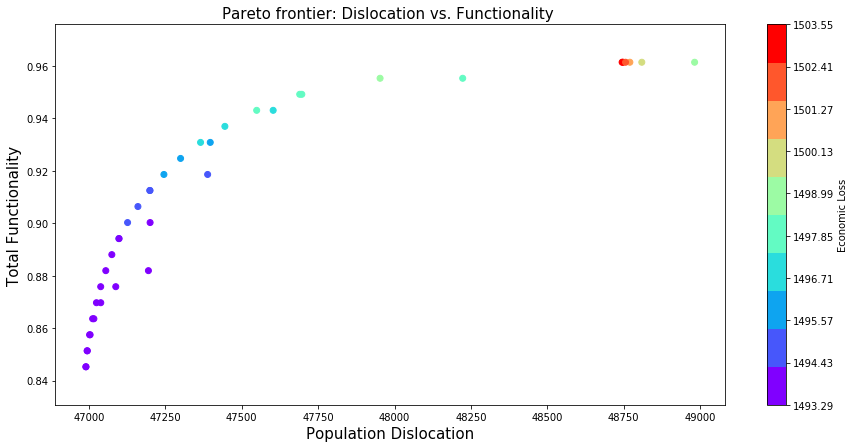

In [121]:
plt.figure(figsize=(15,7))
plt.scatter(dislocation_optimal60,func_optimal60,c=loss_optimal60,cmap=plt.cm.get_cmap('rainbow', 10) )
v1 = np.linspace(min(loss_optimal60), max(loss_optimal60), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Economic Loss' )
plt.clim(min(loss_optimal60), max(loss_optimal60))
plt.xlabel("Population Dislocation",fontsize = 15)
plt.ylabel("Total Functionality",fontsize = 15)
plt.title("Pareto frontier: Dislocation vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal60),",",max(func_optimal60))
print("Range of Dislocation:",min(dislocation_optimal60),",",max(dislocation_optimal60))
print("Range of Economic loss:",min(loss_optimal60),",",max(loss_optimal60))

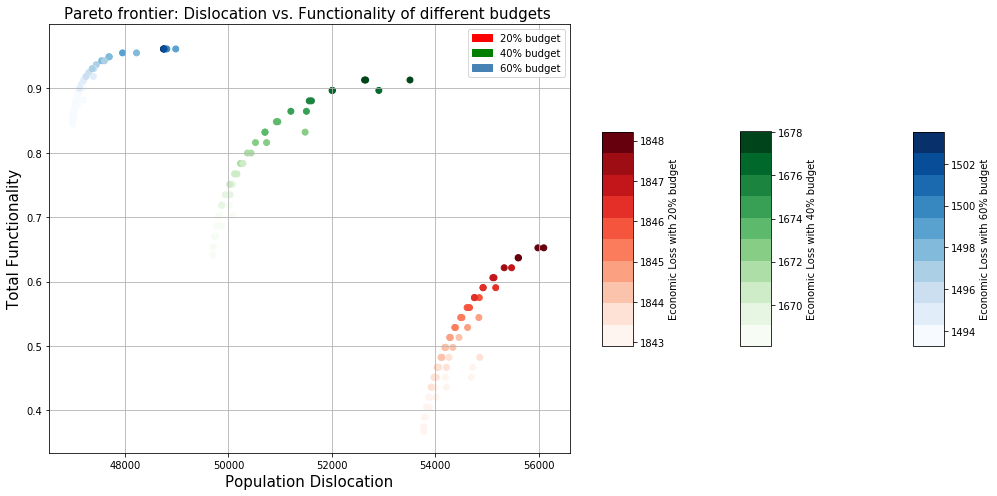

In [122]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,7))
sc1 = ax.scatter(dislocation_optimal60,func_optimal60,c=loss_optimal60,cmap=plt.cm.get_cmap('Blues', 10),label = "60% budget")
#v1 = np.linspace(min(loss_optimal60), max(loss_optimal60), 10, endpoint=True)
fig.colorbar(sc1,shrink=0.5, aspect=7,label = 'Economic Loss with 60% budget')
#legend1 = ax.legend(*sc1.legend_elements(),loc="upper right")
#ax.add_artist(legend1)

sc2 = ax.scatter(dislocation_optimal40,func_optimal40,c=loss_optimal40,cmap=plt.cm.get_cmap('Greens', 10),label = "40% budget" )
#v2 = np.linspace(min(loss_optimal40), max(loss_optimal40), 10, endpoint=True)
fig.colorbar(sc2,shrink=0.5, aspect=7,label = "Economic Loss with 40% budget")
#legend2 = ax.legend(*sc2.legend_elements(),loc="lower right")
#ax.add_artist(legend2)

sc3 = ax.scatter(dislocation_optimal20,func_optimal20,c=loss_optimal20,cmap=plt.cm.get_cmap('Reds', 10) ,label = "20% budget")
#v3 = np.linspace(min(loss_optimal20), max(loss_optimal20), 10, endpoint=True)
fig.colorbar(sc3,shrink=0.5, aspect=7,label = "Economic Loss with 20% budget" )
#legend3 = ax.legend(*sc3.legend_elements(),loc="lower left")
#ax.add_artist(legend3)

ax.set_xlabel("Population Dislocation",fontsize = 15)
ax.set_ylabel("Total Functionality",fontsize = 15)
ax.set_title("Pareto frontier: Dislocation vs. Functionality of different budgets ",fontsize = 15)
fig.tight_layout()

plt.grid()
Budget_20 = mpatches.Patch(color='red', label='20% budget')
Budget_40 = mpatches.Patch(color='green', label='40% budget')
Budget_60 = mpatches.Patch(color='steelblue', label='60% budget')
plt.legend(handles=[Budget_20,Budget_40,Budget_60])


Range of Functionality: 0.8452409861817902 , 0.961438126860042
Range of Dislocation: 46989.974179681725 , 48981.870022028204
Range of Economic loss(Million Dollar): 1493.2852122263942 , 1503.5524043074283


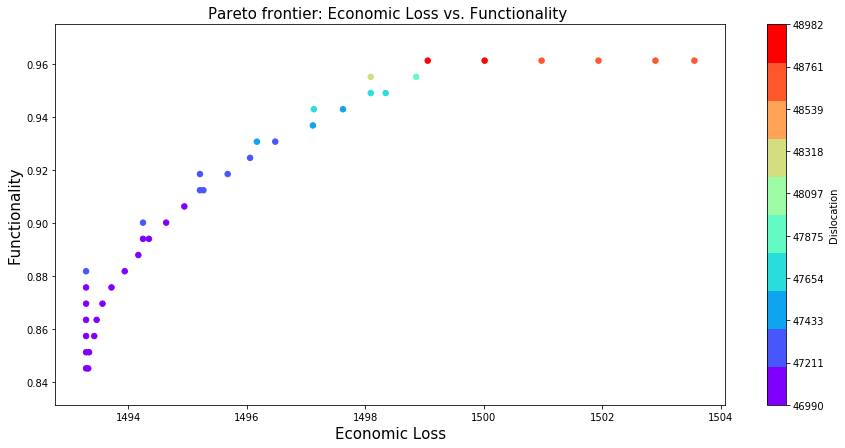

In [132]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal60,func_optimal60,c=dislocation_optimal60,cmap =plt.cm.get_cmap('rainbow', 10),s =30)
v1 = np.linspace(min(dislocation_optimal60), max(dislocation_optimal60), 10, endpoint=True)
plt.colorbar(ticks = v1, label = "Dislocation")
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Functionality",fontsize = 15)
plt.title("Pareto frontier: Economic Loss vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal60),",",max(func_optimal60))
print("Range of Dislocation:",min(dislocation_optimal60),",",max(dislocation_optimal60))
print("Range of Economic loss(Million Dollar):",min(loss_optimal60),",",max(loss_optimal60))

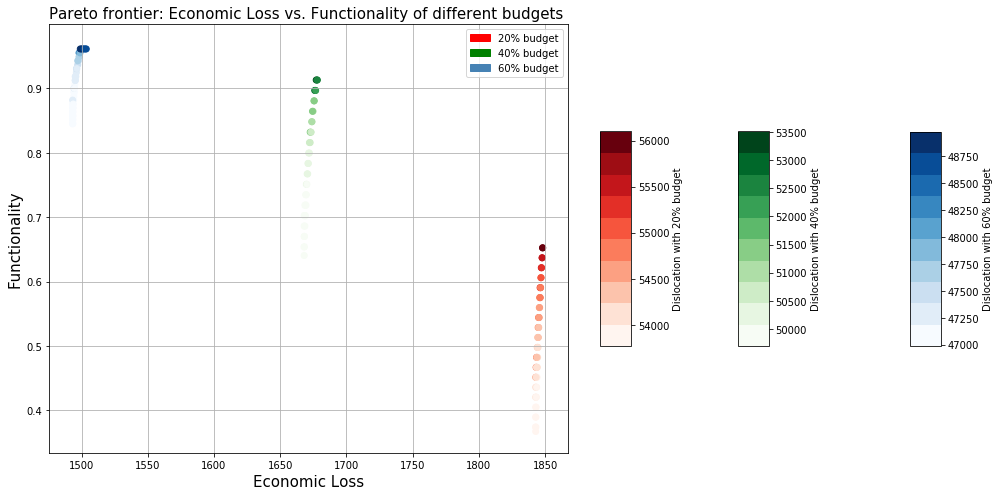

In [124]:

fig,ax = plt.subplots(figsize=(15,7))
sc1 = ax.scatter(loss_optimal60,func_optimal60,c=dislocation_optimal60,cmap =plt.cm.get_cmap('Blues', 10))
fig.colorbar(sc1,shrink=0.5, aspect=7,label = 'Dislocation with 60% budget')
#legend1 = ax.legend(*sc1.legend_elements(),loc="upper right")
#ax.add_artist(legend1)

sc2 = ax.scatter(loss_optimal40,func_optimal40,c=dislocation_optimal40,cmap =plt.cm.get_cmap('Greens', 10))
fig.colorbar(sc2,shrink=0.5, aspect=7,label = "Dislocation with 40% budget")
#legend2 = ax.legend(*sc2.legend_elements(),loc="lower right")
#ax.add_artist(legend2)

sc3 = ax.scatter(loss_optimal20,func_optimal20,c=dislocation_optimal20,cmap =plt.cm.get_cmap('Reds', 10))
#v3 = np.linspace(min(loss_optimal20), max(loss_optimal20), 10, endpoint=True)
fig.colorbar(sc3,shrink=0.5, aspect=7,label = "Dislocation with 20% budget" )
#legend3 = ax.legend(*sc3.legend_elements(),loc="lower left")
#ax.add_artist(legend3)

ax.set_xlabel("Economic Loss",fontsize = 15)
ax.set_ylabel("Functionality",fontsize = 15)
ax.set_title("Pareto frontier: Economic Loss vs. Functionality of different budgets ",fontsize = 15)
fig.tight_layout()

plt.grid()
Budget_20 = mpatches.Patch(color='red', label='20% budget')
Budget_40 = mpatches.Patch(color='green', label='40% budget')
Budget_60 = mpatches.Patch(color='steelblue', label='60% budget')
plt.legend(handles=[Budget_20,Budget_40,Budget_60])


Text(0.5, 1.0, 'Pareto frontier of 60% budget: Population Dislocation vs. Economic Loss ')

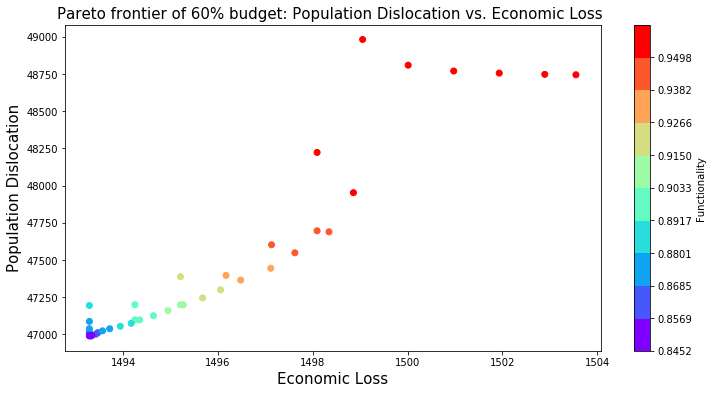

In [125]:
plt.figure(figsize=(12,6))
plt.scatter(loss_optimal60,dislocation_optimal60,c=func_optimal60,cmap =plt.cm.get_cmap('rainbow', 10))
plt.colorbar(ticks=np.arange(min(func_optimal60),max(func_optimal60),(max(func_optimal60)- min(func_optimal60))/10),label="Functionality")
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Population Dislocation",fontsize = 15)
plt.title("Pareto frontier of 60% budget: Population Dislocation vs. Economic Loss ",fontsize = 15)

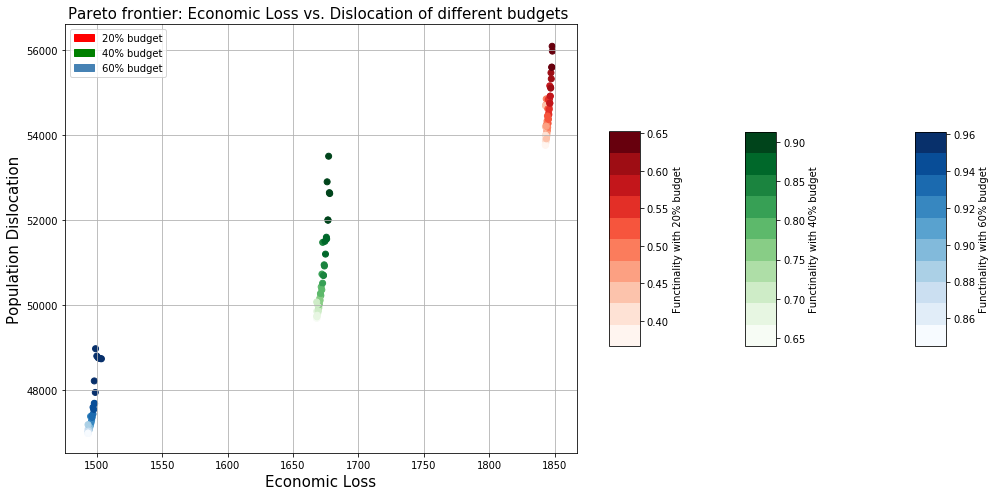

In [126]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,7))
sc1 = ax.scatter(loss_optimal60,dislocation_optimal60,c=func_optimal60,cmap =plt.cm.get_cmap('Blues', 10))
fig.colorbar(sc1,shrink=0.5, aspect=7,label = 'Functinality with 60% budget')
#legend1 = ax.legend(*sc1.legend_elements(),loc="upper right")
#ax.add_artist(legend1)

sc2 = ax.scatter(loss_optimal40,dislocation_optimal40,c=func_optimal40,cmap =plt.cm.get_cmap('Greens', 10))
fig.colorbar(sc2,shrink=0.5, aspect=7,label = "Functinality with 40% budget")
#legend2 = ax.legend(*sc2.legend_elements(),loc="lower right")
#ax.add_artist(legend2)

sc3 = ax.scatter(loss_optimal20,dislocation_optimal20,c=func_optimal20,cmap =plt.cm.get_cmap('Reds', 10))
#v3 = np.linspace(min(loss_optimal20), max(loss_optimal20), 10, endpoint=True)
fig.colorbar(sc3,shrink=0.5, aspect=7,label = "Functinality with 20% budget" )
#legend3 = ax.legend(*sc3.legend_elements(),loc="lower left")
#ax.add_artist(legend3)

ax.set_xlabel("Economic Loss",fontsize = 15)
ax.set_ylabel("Population Dislocation",fontsize = 15)
ax.set_title("Pareto frontier: Economic Loss vs. Dislocation of different budgets ",fontsize = 15)
fig.tight_layout()

plt.grid()
Budget_20 = mpatches.Patch(color='red', label='20% budget')
Budget_40 = mpatches.Patch(color='green', label='40% budget')
Budget_60 = mpatches.Patch(color='steelblue', label='60% budget')
plt.legend(handles=[Budget_20,Budget_40,Budget_60])


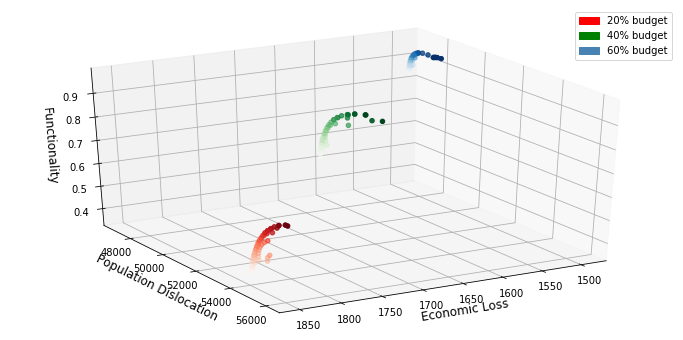

In [130]:
X6 = loss_optimal60
Y6 = dislocation_optimal60
Z6 = func_optimal60
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z,c= Z,cmap=plt.cm.get_cmap('Reds'))
ax.scatter(X2,Y2,Z2,c= Z2,cmap=plt.cm.get_cmap('Greens'))
ax.scatter(X6,Y6,Z6,c= Z6,cmap=plt.cm.get_cmap('Blues'))
#ax.contour3D(plotx,ploty,plotz,100,cmap=plt.cm.get_cmap('Reds', 10))
#ax.contour3D(plotx4,ploty4,plotz4,100,cmap=plt.cm.get_cmap('Greens', 10))
#ax.contour3D(plotx6,ploty6,plotz6, 100,cmap=plt.cm.get_cmap('Blues', 10))
#ax.plot_surface(plotx,ploty,plotz,color = 'blue')
#ax.plot_surface(plotx4,ploty4,plotz4,color = 'orange')
#ax.plot_surface(plotx6,ploty6,plotz6,color = 'green')
ax.set_xlabel('Economic Loss',fontsize = 12)
ax.set_ylabel('Population Dislocation',fontsize = 12)
ax.set_zlabel('Functionality',fontsize = 12)
Budget_20 = mpatches.Patch(color='red', label='20% budget')
Budget_40 = mpatches.Patch(color='green', label='40% budget')
Budget_60 = mpatches.Patch(color='steelblue', label='60% budget')
plt.legend(handles=[Budget_20,Budget_40,Budget_60])
ax.view_init(30,60) # view the plot from different angle
plt.show()

### Optimization 3

### Three competing objectives: epsilon constraints on direct economic loss and dislocation, optimize functionality

### 20% Budget level

In [67]:
# Optimization 3 ###############
# book keeping
listLoss3 = []
listStrategy3_x = []
listStrategy3_y = []
listDislocation3 = []
listDislocationBlockgroup3 = []
listHousingFunctionality3 = []



# epsilon steps
budget_plan = 0.2
eco_range, dislocation_range, func_range = feasible_region(max_budget, budget_plan)
eco_step, dislocation_step,func_step = epsilon_steps(eco_range, dislocation_range,func_range, 0.05)

# optimization: add epsilon constraint on dislocation, opitimize total_direct_loss, 
# and relax total_housing_functionality
counter = 1 
for dislocation_bound in np.arange(dislocation_range[1], dislocation_range[0], dislocation_step):
    print ("--------iteration step", counter,"--------------")
    print("++++++++++++++++++++dislocation bound", dislocation_bound, "++++++++++++++++++")

    for eco_bound in np.arange(eco_range[1], eco_range[0], eco_step):    
    
        print("++++++++++++++++++++econimoc bound", eco_bound, "++++++++++++++++++")

    
    #eco_bound,_, _,_ = epsilon_dislocation_optimize_eco(max_budget*0.5,dislocation_bound)
    
        total_direct_loss,total_dislocation, strategy_x,func,strategy_y =epsilon_ecoloss_dislocation(max_budget*0.2,eco_bound,dislocation_bound)
        if func !=-1: 
            listLoss3.append(total_direct_loss)
            listDislocation3.append(total_dislocation)
            listHousingFunctionality3.append(func)
            listStrategy3_x.append(strategy_x)
            listStrategy3_y.append(strategy_y)
        else:
            print("Infeasible")
    counter += 1
df_def20 = pd.DataFrame({"Economic_bound":epsilon_eco,
                               "Functionality_bound": epsilon_func,
                               "Economic_loss":listLoss3,
                               "Dislocation": listDislocation3, 
                               "Functionality":listHousingFunctionality3})
print("---------------------Overview Result-------------------")
print(df_def20)

loss_optimal_def20, dislocation_optimal_def20,func_optimal_def20 = optimal_points(listLoss3,listDislocation3,listHousingFunctionality3)
df_def20_optimal = pd.DataFrame({
                               "Economic_loss":loss_optimal_def20,
                               "Dislocation":dislocation_optimal_def20, 
                               "Functionality":func_optimal_def20})
print("---------------------Overview Optimal Result-------------------")
print(df_def20_optimal)


Total population dislocation: 60405.11860663609
Total economic loss: 1842916424.0754645
Total housing funcnationality: 0.016926309170042158
Total population dislocation: 56748.16749836423
Total economic loss: 1848954656.5175247
Total housing funcnationality: 0.6678642061386091
--------iteration step 1 --------------
++++++++++++++++++++dislocation bound 53772.3536523475 ++++++++++++++++++
++++++++++++++++++++econimoc bound 1842916424.0754645 ++++++++++++++++++
Total population dislocation: 53772.3536523475
Total economic loss: 1842916424.0754645
Total housing funcnationality: 0.36700780489067475
++++++++++++++++++++econimoc bound 1843218335.6975675 ++++++++++++++++++
Total population dislocation: 53772.3536523475
Total economic loss: 1842916424.0754645
Total housing funcnationality: 0.36700780489067475
++++++++++++++++++++econimoc bound 1843520247.3196704 ++++++++++++++++++
Total population dislocation: 53772.3536523475
Total economic loss: 1842916424.0754645
Total housing funcnational

Total population dislocation: 54103.99190006193
Total economic loss: 1844350056.0310614
Total housing funcnationality: 0.4804683945234999
++++++++++++++++++++econimoc bound 1848350833.273318 ++++++++++++++++++
Total population dislocation: 54103.99190006193
Total economic loss: 1844350056.0310614
Total housing funcnationality: 0.4804683945234999
++++++++++++++++++++econimoc bound 1848652744.895421 ++++++++++++++++++
Total population dislocation: 54103.99190006193
Total economic loss: 1844350056.0310614
Total housing funcnationality: 0.4804683945234999
--------iteration step 3 --------------
++++++++++++++++++++dislocation bound 54435.630147776355 ++++++++++++++++++
++++++++++++++++++++econimoc bound 1842916424.0754645 ++++++++++++++++++
Total population dislocation: 54435.630147776355
Total economic loss: 1842916424.0754645
Total housing funcnationality: 0.4445447550377904
++++++++++++++++++++econimoc bound 1843218335.6975675 ++++++++++++++++++
Total population dislocation: 54435.63014

Total population dislocation: 54767.268395490784
Total economic loss: 1846296844.0450711
Total housing funcnationality: 0.5759306949477865
++++++++++++++++++++econimoc bound 1847747010.029112 ++++++++++++++++++
Total population dislocation: 54767.268395490784
Total economic loss: 1846296844.0450711
Total housing funcnationality: 0.5759306949477865
++++++++++++++++++++econimoc bound 1848048921.651215 ++++++++++++++++++
Total population dislocation: 54767.268395490784
Total economic loss: 1846296844.0450711
Total housing funcnationality: 0.5759306949477865
++++++++++++++++++++econimoc bound 1848350833.273318 ++++++++++++++++++
Total population dislocation: 54767.268395490784
Total economic loss: 1846296844.0450711
Total housing funcnationality: 0.5759306949477865
++++++++++++++++++++econimoc bound 1848652744.895421 ++++++++++++++++++
Total population dislocation: 54767.268395490784
Total economic loss: 1846296844.0450711
Total housing funcnationality: 0.5759306949477865
--------iteration

Total population dislocation: 55430.54489091964
Total economic loss: 1846841275.1628032
Total housing funcnationality: 0.6124212940269809
++++++++++++++++++++econimoc bound 1847143186.7849061 ++++++++++++++++++
Total population dislocation: 55430.54489091964
Total economic loss: 1847143186.7849061
Total housing funcnationality: 0.6205648557428101
++++++++++++++++++++econimoc bound 1847445098.4070091 ++++++++++++++++++
Total population dislocation: 55430.54489091964
Total economic loss: 1847445098.4070091
Total housing funcnationality: 0.626787078626066
++++++++++++++++++++econimoc bound 1847747010.029112 ++++++++++++++++++
Total population dislocation: 55430.54489091964
Total economic loss: 1847541785.46203
Total housing funcnationality: 0.6275285447244024
++++++++++++++++++++econimoc bound 1848048921.651215 ++++++++++++++++++
Total population dislocation: 55430.54489091964
Total economic loss: 1847541785.46203
Total housing funcnationality: 0.6275285447244024
++++++++++++++++++++econi

Total population dislocation: 56093.8213863485
Total economic loss: 1846237451.9185972
Total housing funcnationality: 0.5933150824999637
++++++++++++++++++++econimoc bound 1846539363.5407002 ++++++++++++++++++
Total population dislocation: 56093.8213863485
Total economic loss: 1846539363.5407002
Total housing funcnationality: 0.6041374808340643
++++++++++++++++++++econimoc bound 1846841275.1628032 ++++++++++++++++++
Total population dislocation: 56093.8213863485
Total economic loss: 1846841275.1628032
Total housing funcnationality: 0.6146187072248522
++++++++++++++++++++econimoc bound 1847143186.7849061 ++++++++++++++++++
Total population dislocation: 56093.8213863485
Total economic loss: 1847143186.7849061
Total housing funcnationality: 0.6248668889405615
++++++++++++++++++++econimoc bound 1847445098.4070091 ++++++++++++++++++
Total population dislocation: 56093.8213863485
Total economic loss: 1847445098.4070091
Total housing funcnationality: 0.6347063442671673
++++++++++++++++++++eco

Total population dislocation: 56178.922486591095
Total economic loss: 1845633628.6743913
Total housing funcnationality: 0.5709050495974751
++++++++++++++++++++econimoc bound 1845935540.2964942 ++++++++++++++++++
Total population dislocation: 56317.45267414281
Total economic loss: 1845935540.2964942
Total housing funcnationality: 0.5822662351666833
++++++++++++++++++++econimoc bound 1846237451.9185972 ++++++++++++++++++
Total population dislocation: 56400.181230105576
Total economic loss: 1846237451.9185972
Total housing funcnationality: 0.5933795107362839
++++++++++++++++++++econimoc bound 1846539363.5407002 ++++++++++++++++++
Total population dislocation: 56416.540212375505
Total economic loss: 1846539363.5407002
Total housing funcnationality: 0.6042307812823405
++++++++++++++++++++econimoc bound 1846841275.1628032 ++++++++++++++++++
Total population dislocation: 56471.00210445321
Total economic loss: 1846841275.1628032
Total housing funcnationality: 0.6147748072316505
+++++++++++++++

Total population dislocation: 55947.873166857
Total economic loss: 1845029805.4301853
Total housing funcnationality: 0.5472247847120584
++++++++++++++++++++econimoc bound 1845331717.0522883 ++++++++++++++++++
Total population dislocation: 56030.40950592846
Total economic loss: 1845331717.0522883
Total housing funcnationality: 0.5592278466010534
++++++++++++++++++++econimoc bound 1845633628.6743913 ++++++++++++++++++
Total population dislocation: 56179.89945151291
Total economic loss: 1845633628.6743913
Total housing funcnationality: 0.5709050463994878
++++++++++++++++++++econimoc bound 1845935540.2964942 ++++++++++++++++++
Total population dislocation: 56317.40661410268
Total economic loss: 1845935540.2964942
Total housing funcnationality: 0.5822662353626852
++++++++++++++++++++econimoc bound 1846237451.9185972 ++++++++++++++++++
Total population dislocation: 56397.8452536572
Total economic loss: 1846237451.9185972
Total housing funcnationality: 0.5933795123785751
++++++++++++++++++++e

Total population dislocation: 55812.03265021724
Total economic loss: 1844425982.1859794
Total housing funcnationality: 0.5221423624508886
++++++++++++++++++++econimoc bound 1844727893.8080823 ++++++++++++++++++
Total population dislocation: 55877.559857090404
Total economic loss: 1844727893.8080823
Total housing funcnationality: 0.5349331457440644
++++++++++++++++++++econimoc bound 1845029805.4301853 ++++++++++++++++++
Total population dislocation: 55951.693292016615
Total economic loss: 1845029805.4301853
Total housing funcnationality: 0.547224795231753
++++++++++++++++++++econimoc bound 1845331717.0522883 ++++++++++++++++++
Total population dislocation: 56026.91393984135
Total economic loss: 1845331717.0522883
Total housing funcnationality: 0.5592278423108188
++++++++++++++++++++econimoc bound 1845633628.6743913 ++++++++++++++++++
Total population dislocation: 56179.89945151291
Total economic loss: 1845633628.6743913
Total housing funcnationality: 0.5709050463994878
+++++++++++++++++

Total population dislocation: 55505.53771944115
Total economic loss: 1843822158.9417734
Total housing funcnationality: 0.49641416414746503
++++++++++++++++++++econimoc bound 1844124070.5638764 ++++++++++++++++++
Total population dislocation: 55634.15747514958
Total economic loss: 1844124070.5638764
Total housing funcnationality: 0.5095027339228997
++++++++++++++++++++econimoc bound 1844425982.1859794 ++++++++++++++++++
Total population dislocation: 55757.84792411242
Total economic loss: 1844425982.1859794
Total housing funcnationality: 0.5223668523852518
++++++++++++++++++++econimoc bound 1844727893.8080823 ++++++++++++++++++
Total population dislocation: 55876.00452552179
Total economic loss: 1844727893.8080823
Total housing funcnationality: 0.5349331377013287
++++++++++++++++++++econimoc bound 1845029805.4301853 ++++++++++++++++++
Total population dislocation: 55947.873166857
Total economic loss: 1845029805.4301853
Total housing funcnationality: 0.5472247847120584
+++++++++++++++++++

Total population dislocation: 55296.774443518545
Total economic loss: 1843218335.6975675
Total housing funcnationality: 0.4693855870328205
++++++++++++++++++++econimoc bound 1843520247.3196704 ++++++++++++++++++
Total population dislocation: 55404.840986278825
Total economic loss: 1843520247.3196704
Total housing funcnationality: 0.4830463462276666
++++++++++++++++++++econimoc bound 1843822158.9417734 ++++++++++++++++++
Total population dislocation: 55505.53771944115
Total economic loss: 1843822158.9417734
Total housing funcnationality: 0.49641416414746503
++++++++++++++++++++econimoc bound 1844124070.5638764 ++++++++++++++++++
Total population dislocation: 55632.041692457395
Total economic loss: 1844124070.5638764
Total housing funcnationality: 0.5095027272855249
++++++++++++++++++++econimoc bound 1844425982.1859794 ++++++++++++++++++
Total population dislocation: 55757.84792411242
Total economic loss: 1844425982.1859794
Total housing funcnationality: 0.5223668523852518
++++++++++++++

Total population dislocation: 55209.1732298938
Total economic loss: 1842916424.0754645
Total housing funcnationality: 0.4555009874325736
++++++++++++++++++++econimoc bound 1843218335.6975675 ++++++++++++++++++
Total population dislocation: 55296.774443518545
Total economic loss: 1843218335.6975675
Total housing funcnationality: 0.4693855870328205
++++++++++++++++++++econimoc bound 1843520247.3196704 ++++++++++++++++++
Total population dislocation: 55404.840986278825
Total economic loss: 1843520247.3196704
Total housing funcnationality: 0.4830463462276666
++++++++++++++++++++econimoc bound 1843822158.9417734 ++++++++++++++++++
Total population dislocation: 55505.53771944115
Total economic loss: 1843822158.9417734
Total housing funcnationality: 0.49641416414746503
++++++++++++++++++++econimoc bound 1844124070.5638764 ++++++++++++++++++
Total population dislocation: 55632.041692457395
Total economic loss: 1844124070.5638764
Total housing funcnationality: 0.5095027272855249
+++++++++++++++

ValueError: arrays must all be same length

In [68]:
loss_optimal_def20, dislocation_optimal_def20,func_optimal_def20 = optimal_points(listLoss3,listDislocation3,listHousingFunctionality3)
df_def20_optimal = pd.DataFrame({
                               "Economic_loss":loss_optimal_def20,
                               "Dislocation":dislocation_optimal_def20, 
                               "Functionality":func_optimal_def20})
print("---------------------Overview Optimal Result-------------------")
print(df_def20_optimal)

---------------------Overview Optimal Result-------------------
     Economic_loss   Dislocation  Functionality
0     1.846539e+09  56418.556039       0.604231
1     1.843218e+09  55295.643624       0.469386
2     1.846539e+09  56418.544149       0.604231
3     1.843822e+09  55505.537719       0.496414
4     1.843218e+09  55098.906643       0.469371
5     1.845332e+09  54435.630148       0.536520
6     1.846539e+09  55098.906643       0.598079
7     1.846841e+09  56093.821386       0.614619
8     1.844728e+09  55869.064870       0.534933
9     1.844728e+09  54767.268395       0.531463
10    1.844426e+09  55098.906643       0.522058
11    1.845634e+09  55098.906643       0.569172
12    1.845030e+09  55762.183139       0.547211
13    1.844728e+09  55875.742057       0.534933
14    1.847445e+09  56539.900924       0.635107
15    1.848653e+09  56738.168936       0.667783
16    1.843822e+09  55509.517110       0.496414
17    1.843822e+09  54435.630148       0.487877
18    1.842916e+09  5520

In [69]:
X3_20 = listLoss3
Y3_20 = listDislocation3
Z3_20 = listHousingFunctionality3
plotx3_20,ploty3_20, = np.meshgrid(np.linspace(np.min(X3_20),np.max(X3_20),10),\
                           np.linspace(np.min(Y3_20),np.max(Y3_20),10))
plotz3_20 = interp.griddata((X3_20,Y3_20),Z3_20,(plotx3_20,ploty3_20),method='linear')

Range of Functionality: 0.3670078048906748 , 0.6677832114022232
Range of Dislocation: 53772.3536523475 , 56738.16893633638
Range of Economic loss(Million Dollar): 1842916424.0754645 , 1848652744.895421


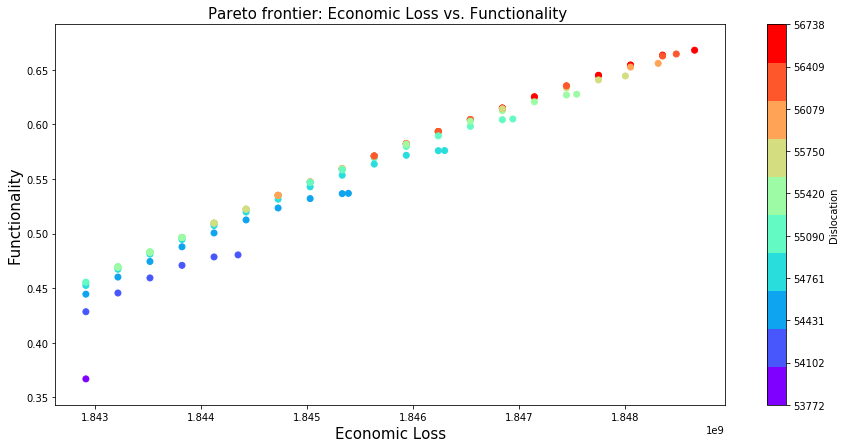

In [70]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal_def20,func_optimal_def20,c=dislocation_optimal_def20,cmap=plt.cm.get_cmap('rainbow', 10) )
v1 = np.linspace(min(dislocation_optimal_def20), max(dislocation_optimal_def20), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Dislocation' )
plt.clim(min(dislocation_optimal_def20), max(dislocation_optimal_def20))
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Functionality",fontsize = 15)
plt.title("Pareto frontier: Economic Loss vs. Functionality ",fontsize = 15)
print("Range of Functionality:",min(func_optimal_def20),",",max(func_optimal_def20))
print("Range of Dislocation:",min(dislocation_optimal_def20),",",max(dislocation_optimal_def20))
print("Range of Economic loss(Million Dollar):",min(loss_optimal_def20),",",max(loss_optimal_def20))

Range of Functionality: 0.3670078048906748 , 0.6677832114022232
Range of Dislocation: 53772.3536523475 , 56738.16893633638
Range of Economic loss(Million Dollar): 1842916424.0754645 , 1848652744.895421


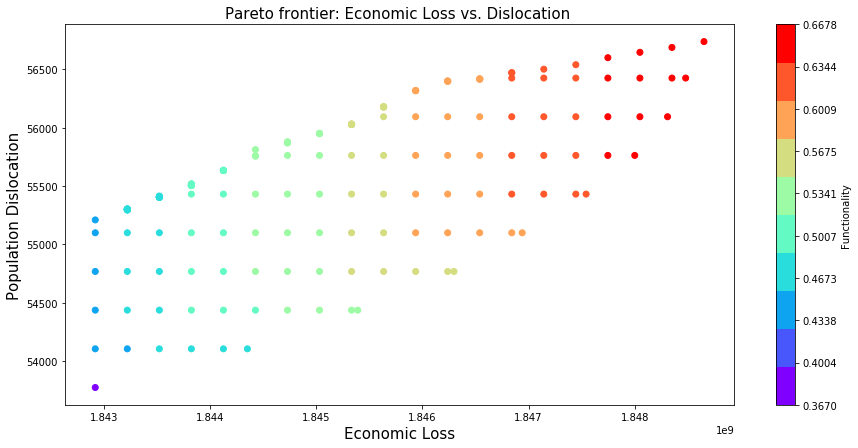

In [71]:
plt.figure(figsize=(15,7))
plt.scatter(loss_optimal_def20,dislocation_optimal_def20,c=func_optimal_def20,cmap=plt.cm.get_cmap('rainbow', 10) )
v1 = np.linspace(min(func_optimal_def20), max(func_optimal_def20), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Functionality' )
plt.clim(min(func_optimal_def20), max(func_optimal_def20))
plt.xlabel("Economic Loss",fontsize = 15)
plt.ylabel("Population Dislocation",fontsize = 15)
plt.title("Pareto frontier: Economic Loss vs. Dislocation ",fontsize = 15)
print("Range of Functionality:",min(func_optimal_def20),",",max(func_optimal_def20))
print("Range of Dislocation:",min(dislocation_optimal_def20),",",max(dislocation_optimal_def20))
print("Range of Economic loss(Million Dollar):",min(loss_optimal_def20),",",max(loss_optimal_def20))

Range of Functionality: 0.3670078048906748 , 0.6677832114022232
Range of Dislocation: 53772.3536523475 , 56738.16893633638
Range of Economic loss(Million Dollar): 1842916424.0754645 , 1848652744.895421


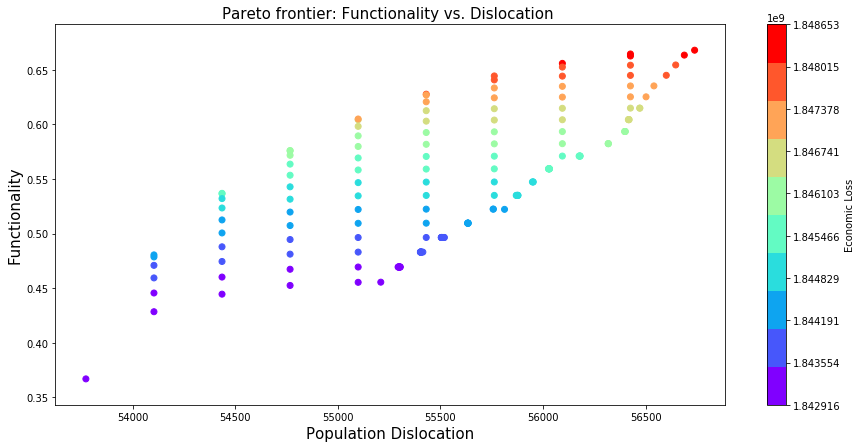

In [72]:
plt.figure(figsize=(15,7))
plt.scatter(dislocation_optimal_def20,func_optimal_def20,c=loss_optimal_def20,cmap=plt.cm.get_cmap('rainbow', 10) )
v1 = np.linspace(min(loss_optimal_def20), max(loss_optimal_def20), 10, endpoint=True)
plt.colorbar(ticks = v1,label='Economic Loss' )
plt.clim(min(loss_optimal_def20), max(loss_optimal_def20))
plt.xlabel("Population Dislocation",fontsize = 15)
plt.ylabel("Functionality",fontsize = 15)
plt.title("Pareto frontier: Functionality vs. Dislocation ",fontsize = 15)
print("Range of Functionality:",min(func_optimal_def20),",",max(func_optimal_def20))
print("Range of Dislocation:",min(dislocation_optimal_def20),",",max(dislocation_optimal_def20))
print("Range of Economic loss(Million Dollar):",min(loss_optimal_def20),",",max(loss_optimal_def20))

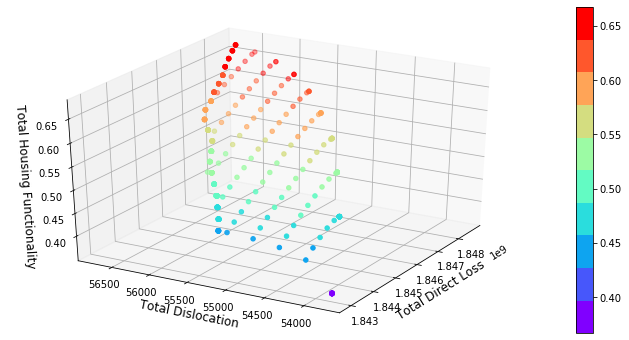

In [73]:
X3 = listLoss3
Y3 = listDislocation3
Z3 = listHousingFunctionality3
#X = list(sorted_dict_l.values())
#Y = list(sorted_dict_d.values())
#Z = list(sorted_dict_f.values())
plotx3,ploty3, = np.meshgrid(np.linspace(np.min(X3),np.max(X3),10),\
                           np.linspace(np.min(Y3),np.max(Y3),10))
plotz3 = interp.griddata((X3,Y3),Z3,(plotx,ploty),method='linear')

#for angle in range(0, 360):
    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
#pareto_3d = ax.plot_surface(plotx,ploty,plotz,linewidth=0, antialiased=False) 
#ax.plot_wireframe(plotx,ploty,plotz)
sc = ax.scatter(X3,Y3,Z3,c = Z3, cmap =cm)
plt.colorbar(sc)
ax.set_xlabel('Total Direct Loss',fontsize = 12)

ax.set_ylabel('Total Dislocation',fontsize = 12)
ax.set_zlabel('Total Housing Functionality',fontsize = 12)

#fig.colorbar(pareto_3d, shrink=0.5, aspect=5)
ax.view_init(30,210) # view the plot from different angle
#plt.pause(.001)
plt.show()